# 1. Packages

In [117]:
import numpy as np 
import pandas as pd 
import datetime
import math
from collections import defaultdict
import itertools
from scipy.stats import shapiro
import scipy.stats as stats
import matplotlib.pyplot as plt 
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV, ElasticNet
from xgboost import XGBRegressor
import catboost as cb
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error,make_scorer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.compose import make_column_selector as selector

#Configurations
from warnings import simplefilter
simplefilter("ignore")  # ignore warnings to clean up output cells
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# 2. Import Data

> 

In [118]:
train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

holidays_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
submission_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
submission_data.rename(columns = {'id':'id', 'sales':'submission_d'}, inplace = True )
stores_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

holidays_data['date'] = pd.to_datetime(holidays_data['date'], format = "%Y-%m-%d")
oil_data['date'] = pd.to_datetime(oil_data['date'], format = "%Y-%m-%d")
transactions_data['date'] = pd.to_datetime(transactions_data['date'], format = "%Y-%m-%d")
train_data['date'] = pd.to_datetime(train_data['date'], format = "%Y-%m-%d")
test_data['date'] = pd.to_datetime(test_data['date'], format = "%Y-%m-%d")

# 3.Pre-Processing

**3.1 Missing dates in data**

Here we can see train_data:

In [3]:
train_data.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

In [119]:
train_data_start = train_data.date.min().date()
train_data_end = train_data.date.max().date()

missing_dates = pd.date_range(train_data_start, train_data_end
                             ).difference(train_data.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

missing_dates

['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']

It is very important that there are no gaps in the dates, so let’s assume that the stores were closed on this day and therefore fill the data with zeros

In [120]:
# reindex training data
multi_idx = pd.MultiIndex.from_product([pd.date_range(train_data_start, train_data_end), 
                                        train_data.store_nbr.unique(), 
                                        train_data.family.unique()],
                                        names=["date", "store_nbr", "family"],)
train_data = train_data.set_index(["date", "store_nbr", "family"]
                                 ).reindex(multi_idx).reset_index()
# fill missing values with 0s
train_data[["sales", "onpromotion"]] = train_data[["sales", "onpromotion"]].fillna(0.)
# interpolate  for the 'id'
train_data.id = train_data.id.interpolate(method="linear")

train_data

date  store_nbr                      family         id   sales  \
0       2013-01-01          1                  AUTOMOTIVE       0.00    0.00   
1       2013-01-01          1                   BABY CARE       1.00    0.00   
2       2013-01-01          1                      BEAUTY       2.00    0.00   
3       2013-01-01          1                   BEVERAGES       3.00    0.00   
4       2013-01-01          1                       BOOKS       4.00    0.00   
...            ...        ...                         ...        ...     ...   
3008011 2017-08-15          9                     POULTRY 3000883.00  438.13   
3008012 2017-08-15          9              PREPARED FOODS 3000884.00  154.55   
3008013 2017-08-15          9                     PRODUCE 3000885.00 2419.73   
3008014 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES 3000886.00  121.00   
3008015 2017-08-15          9                     SEAFOOD 3000887.00   16.00   

         onpromotion  
0               0.00  
1               0.00  
2               0.00  
3               0.00  
4               0.00  
...              ...  
3008011         0.00  
3008012         1.00  
3008013       148.00  
3008014         8.00  
3008015         0.00  

[3008016 rows x 6 columns]

Here we can see test_data:

In [6]:
test_data.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [121]:
test_data_start = test_data.date.min().date()
test_data_end = test_data.date.max().date()

missing_dates_test = pd.date_range(test_data_start, test_data_end
                             ).difference(test_data.date.unique())
missing_dates_test = missing_dates_test.strftime("%Y-%m-%d").tolist()

missing_dates_test

[]

How we can notice there are no gaps in the test data.


In [122]:
#let's add an additional column that will help us separate test and training data in the future
test_data['test'] = 1
train_data['test'] = 0

**3.2 Oil prices**

Here we can see oil_data:

In [9]:
oil_data.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

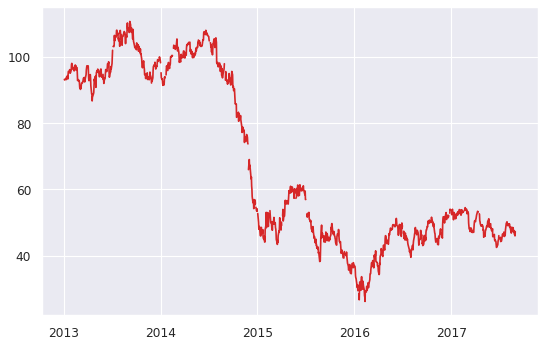

In [123]:
plt.figure(figsize=(8,5), dpi= 80)
plt.plot('date', 'dcoilwtico', data=oil_data, color='tab:red')
plt.show()

As we can see, oil prices are not known on all days, therefore we will use interpolation to fill in the gaps

In [124]:
# reindex oil data
oil_data = oil_data.merge(pd.DataFrame({"date": pd.date_range(train_data_start, 
                                                              test_data_end)}),
                          on="date",how="outer",).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil_data.dcoilwtico = oil_data.dcoilwtico.interpolate(method="linear", limit_direction="both")


**3.3 Transactions**

Here we can see transactions_data:

In [13]:
transactions_data.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

Fill in the missing values ​​for transactions using interpolation, except for days with zero sales

In [125]:
num_store = train_data.store_nbr.nunique()
train_len = (train_data_end - train_data_start).days + 1

num_zero_sales = (train_data.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(transactions_data.index)
missing_rec = total_rec - curr_rec - num_zero_sales

#total sales for each store
store_sales = train_data.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transactions_data = transactions_data.merge(
    store_sales, on=["date", "store_nbr"],how="outer").sort_values(
    ["date", "store_nbr"],ignore_index=True)

# fill missing values with 0s for days with zero sales
transactions_data.loc[transactions_data.sales.eq(0), "transactions"] = 0
transactions_data = transactions_data.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transactions_data.transactions = transactions_data.groupby(
    "store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both"))

**3.4 Holidays and impacts on sales**

In [15]:
#Here we can see holidays_data:
holidays_data.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

Let's look at the quantitative ratio of holidays in different categories

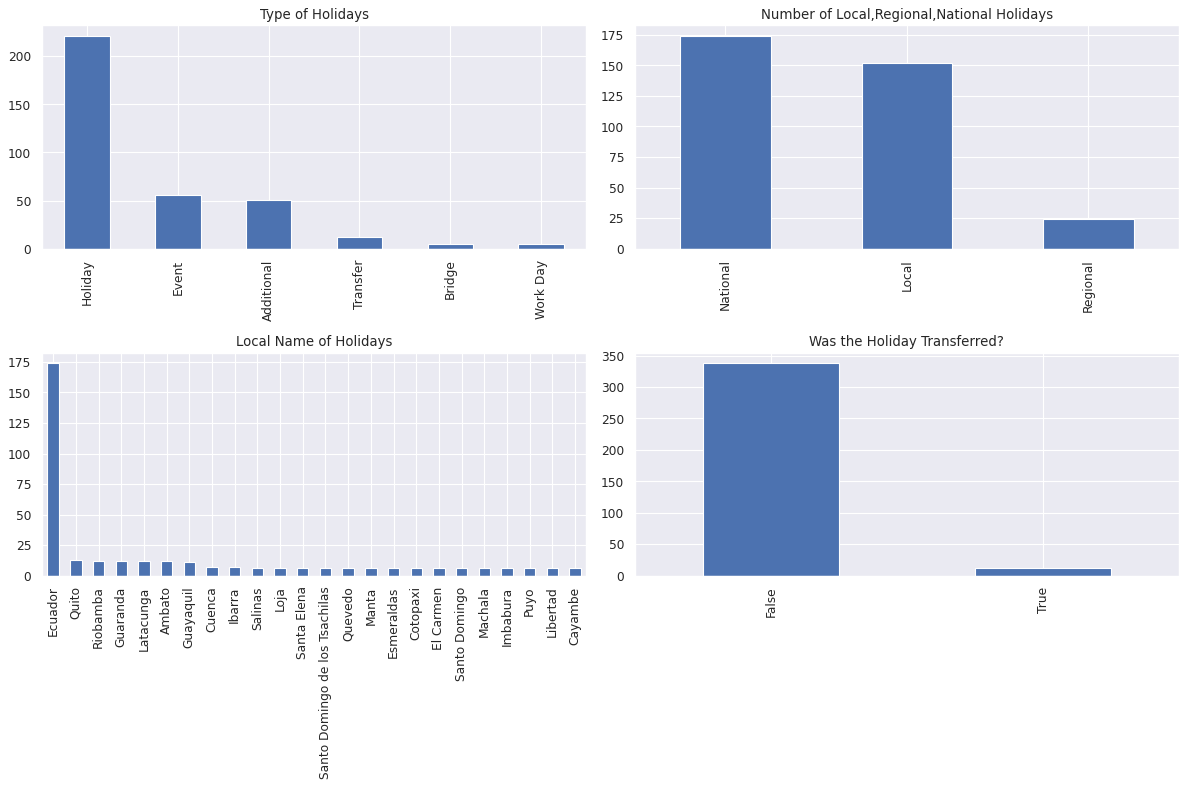

In [126]:
plt.figure(figsize=(15, 10), dpi= 80)
plt.subplot (2, 2, 1)
holidays_type = holidays_data['type'].value_counts().plot.bar().set_title('Type of Holidays')
plt.subplot (2, 2, 2)
holidays_locale = holidays_data['locale'].value_counts().plot.bar().set_title('Number of Local,Regional,National Holidays')
plt.subplot (2, 2, 3)
holidays_locale_name = holidays_data['locale_name'].value_counts().plot.bar().set_title('Local Name of Holidays')
plt.subplot (2, 2, 4)
holidays_transferred = holidays_data['transferred'].value_counts().plot.bar().set_title('Was the Holiday Transferred?')
plt. tight_layout ()
plt.show()

As we can see the most popular types are Holiday,National,Ecuador

In [127]:
print('Holidays types:', holidays_data['type'].unique())
print('Holidays region types:', holidays_data['locale'].unique()) 
print('Holidays locale names:', holidays_data['locale_name'].unique())  

national_locale_name = sorted(holidays_data[holidays_data['locale']=="National"
                                           ]['locale_name'].unique().tolist())
regional_locale_name = sorted(holidays_data[holidays_data['locale']=="Regional"
                                           ]['locale_name'].unique().tolist())
local_locale_name = sorted(holidays_data[holidays_data['locale']=="Local"
                                        ]['locale_name'].unique().tolist())

print(f'Locale names for national holidays:{national_locale_name}')
print(f'Locale names for regional holidays:{regional_locale_name}')
print(f'Locale names for local holidays:{local_locale_name}')

Holidays types: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Holidays region types: ['Local' 'Regional' 'National']
Holidays locale names: ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
Locale names for national holidays:['Ecuador']
Locale names for regional holidays:['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']
Locale names for local holidays:['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


In [128]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(stores_data['city'].str.lower()) | set(stores_data['state'].str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

holidays_data['description'] = holidays_data.apply(
    lambda x: x['description'].lower().replace(x['locale_name'].lower(), ""), 
    axis=1,).apply(process_holiday).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,).replace(
    r"\s+|-", " ", regex=True,).str.strip()

# remove transferred holidays
holidays_data = holidays_data[holidays_data['transferred'].eq(False)]

#Saturdays designated as work days 
work_days = holidays_data[holidays_data['type'].eq("Work Day")]
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}
                                              ).reset_index(drop=True)
work_days['work_day'] = work_days['work_day'].notna().astype(int)

# remove work days after extracting above
holidays_data = holidays_data[holidays_data['type']!="Work Day"].reset_index(drop=True)
holidays_data

date        type    locale locale_name        description  \
0   2012-03-02     Holiday     Local       Manta          fundacion   
1   2012-04-01     Holiday  Regional    Cotopaxi  provincializacion   
2   2012-04-12     Holiday     Local      Cuenca          fundacion   
3   2012-04-14     Holiday     Local    Libertad      cantonizacion   
4   2012-04-21     Holiday     Local    Riobamba      cantonizacion   
..         ...         ...       ...         ...                ...   
328 2017-12-22  Additional  National     Ecuador            navidad   
329 2017-12-23  Additional  National     Ecuador            navidad   
330 2017-12-24  Additional  National     Ecuador            navidad   
331 2017-12-25     Holiday  National     Ecuador            navidad   
332 2017-12-26  Additional  National     Ecuador            navidad   

     transferred  
0          False  
1          False  
2          False  
3          False  
4          False  
..           ...  
328        False  
329        False  
330        False  
331        False  
332        False  

[333 rows x 6 columns]

In [129]:
#local holidays (city level) 
local_holidays = holidays_data[holidays_data['locale'].eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}).reset_index(drop=True)

local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

local_holidays.head()

date      city  loc_cantonizacion  loc_fundacion  loc_independencia
0 2012-03-02     Manta                  0              1                  0
1 2012-04-12    Cuenca                  0              1                  0
2 2012-04-14  Libertad                  1              0                  0
3 2012-04-21  Riobamba                  1              0                  0
4 2012-05-12      Puyo                  1              0                  0

In [130]:
#regional holidays 
regional_holidays = holidays_data[holidays_data['locale'].eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}).reset_index(drop=True)
regional_holidays['provincializacion'] = regional_holidays['provincializacion'].eq(
    "provincializacion").astype(int)

regional_holidays

date                           state  provincializacion
0  2012-04-01                        Cotopaxi                  1
1  2012-06-25                        Imbabura                  1
2  2012-11-06  Santo Domingo de los Tsachilas                  1
3  2012-11-07                     Santa Elena                  1
4  2013-04-01                        Cotopaxi                  1
5  2013-06-25                        Imbabura                  1
6  2013-11-06  Santo Domingo de los Tsachilas                  1
7  2013-11-07                     Santa Elena                  1
8  2014-04-01                        Cotopaxi                  1
9  2014-06-25                        Imbabura                  1
10 2014-11-06  Santo Domingo de los Tsachilas                  1
11 2014-11-07                     Santa Elena                  1
12 2015-04-01                        Cotopaxi                  1
13 2015-06-25                        Imbabura                  1
14 2015-11-06  Santo Domingo de los Tsachilas                  1
15 2015-11-07                     Santa Elena                  1
16 2016-04-01                        Cotopaxi                  1
17 2016-06-25                        Imbabura                  1
18 2016-11-06  Santo Domingo de los Tsachilas                  1
19 2016-11-07                     Santa Elena                  1
20 2017-04-01                        Cotopaxi                  1
21 2017-06-25                        Imbabura                  1
22 2017-11-06  Santo Domingo de los Tsachilas                  1
23 2017-11-07                     Santa Elena                  1

In [131]:
#national holidays 
national_holidays = holidays_data[holidays_data['locale'].eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")

# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={
    "nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

date  nat_batalla  nat_black friday  nat_carnaval  nat_cyber monday  \
0 2012-08-10            0                 0             0                 0   
1 2012-10-12            0                 0             0                 0   
2 2012-11-02            0                 0             0                 0   
3 2012-11-03            0                 0             0                 0   
4 2012-12-21            0                 0             0                 0   

   nat_dia difuntos  nat_dia la madre  nat_dia trabajo  nat_futbol  \
0                 0                 0                0           0   
1                 0                 0                0           0   
2                 1                 0                0           0   
3                 0                 0                0           0   
4                 0                 0                0           0   

   nat_independencia  nat_navidad  nat_primer dia ano  nat_primer grito  \
0                  0            0                   0                 1   
1                  1            0                   0                 0   
2                  0            0                   0                 0   
3                  1            0                   0                 0   
4                  0            1                   0                 0   

   nat_terremoto  nat_viernes santo  
0              0                  0  
1              0                  0  
2              0                  0  
3              0                  0  
4              0                  0

In [132]:
sales_ts = pd.pivot_table(train_data, values="sales", index="date", 
                          columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(transactions_data, values="transactions", index="date", 
                       columns="store_nbr")
promo_ts = pd.pivot_table(train_data, values="onpromotion", index="date", 
                          columns=["store_nbr", "family"])

Here we can see stores_data:

In [23]:
stores_data.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [133]:
# scale target series
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,).reset_index().merge(
    stores_data, on="store_nbr", how="left").merge(
    work_days, on="date", how="left").merge(
    local_holidays, on=["date", "city"], how="left").merge(
    regional_holidays, on=["date", "state"], how="left").merge(
    national_holidays, on="date", how="left").fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith((
    "loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(
    axis=1).eq(0).astype(int)

holiday_sales_merged.head()

date  store_nbr      family  sales   city      state type  cluster  \
0 2013-01-01          1  AUTOMOTIVE   0.00  Quito  Pichincha    D       13   
1 2013-01-02          1  AUTOMOTIVE   0.11  Quito  Pichincha    D       13   
2 2013-01-03          1  AUTOMOTIVE   0.16  Quito  Pichincha    D       13   
3 2013-01-04          1  AUTOMOTIVE   0.16  Quito  Pichincha    D       13   
4 2013-01-05          1  AUTOMOTIVE   0.26  Quito  Pichincha    D       13   

   work_day  loc_cantonizacion  loc_fundacion  loc_independencia  \
0      0.00               0.00           0.00               0.00   
1      0.00               0.00           0.00               0.00   
2      0.00               0.00           0.00               0.00   
3      0.00               0.00           0.00               0.00   
4      1.00               0.00           0.00               0.00   

   provincializacion  nat_batalla  nat_black friday  nat_carnaval  \
0               0.00         0.00              0.00          0.00   
1               0.00         0.00              0.00          0.00   
2               0.00         0.00              0.00          0.00   
3               0.00         0.00              0.00          0.00   
4               0.00         0.00              0.00          0.00   

   nat_cyber monday  nat_dia difuntos  nat_dia la madre  nat_dia trabajo  \
0              0.00              0.00              0.00             0.00   
1              0.00              0.00              0.00             0.00   
2              0.00              0.00              0.00             0.00   
3              0.00              0.00              0.00             0.00   
4              0.00              0.00              0.00             0.00   

   nat_futbol  nat_independencia  nat_navidad  nat_primer dia ano  \
0        0.00               0.00         0.00                1.00   
1        0.00               0.00         0.00                0.00   
2        0.00               0.00         0.00                0.00   
3        0.00               0.00         0.00                0.00   
4        0.00               0.00         0.00                0.00   

   nat_primer grito  nat_terremoto  nat_viernes santo  no_holiday  
0              0.00           0.00               0.00           0  
1              0.00           0.00               0.00           1  
2              0.00           0.00               0.00           1  
3              0.00           0.00               0.00           1  
4              0.00           0.00               0.00           1

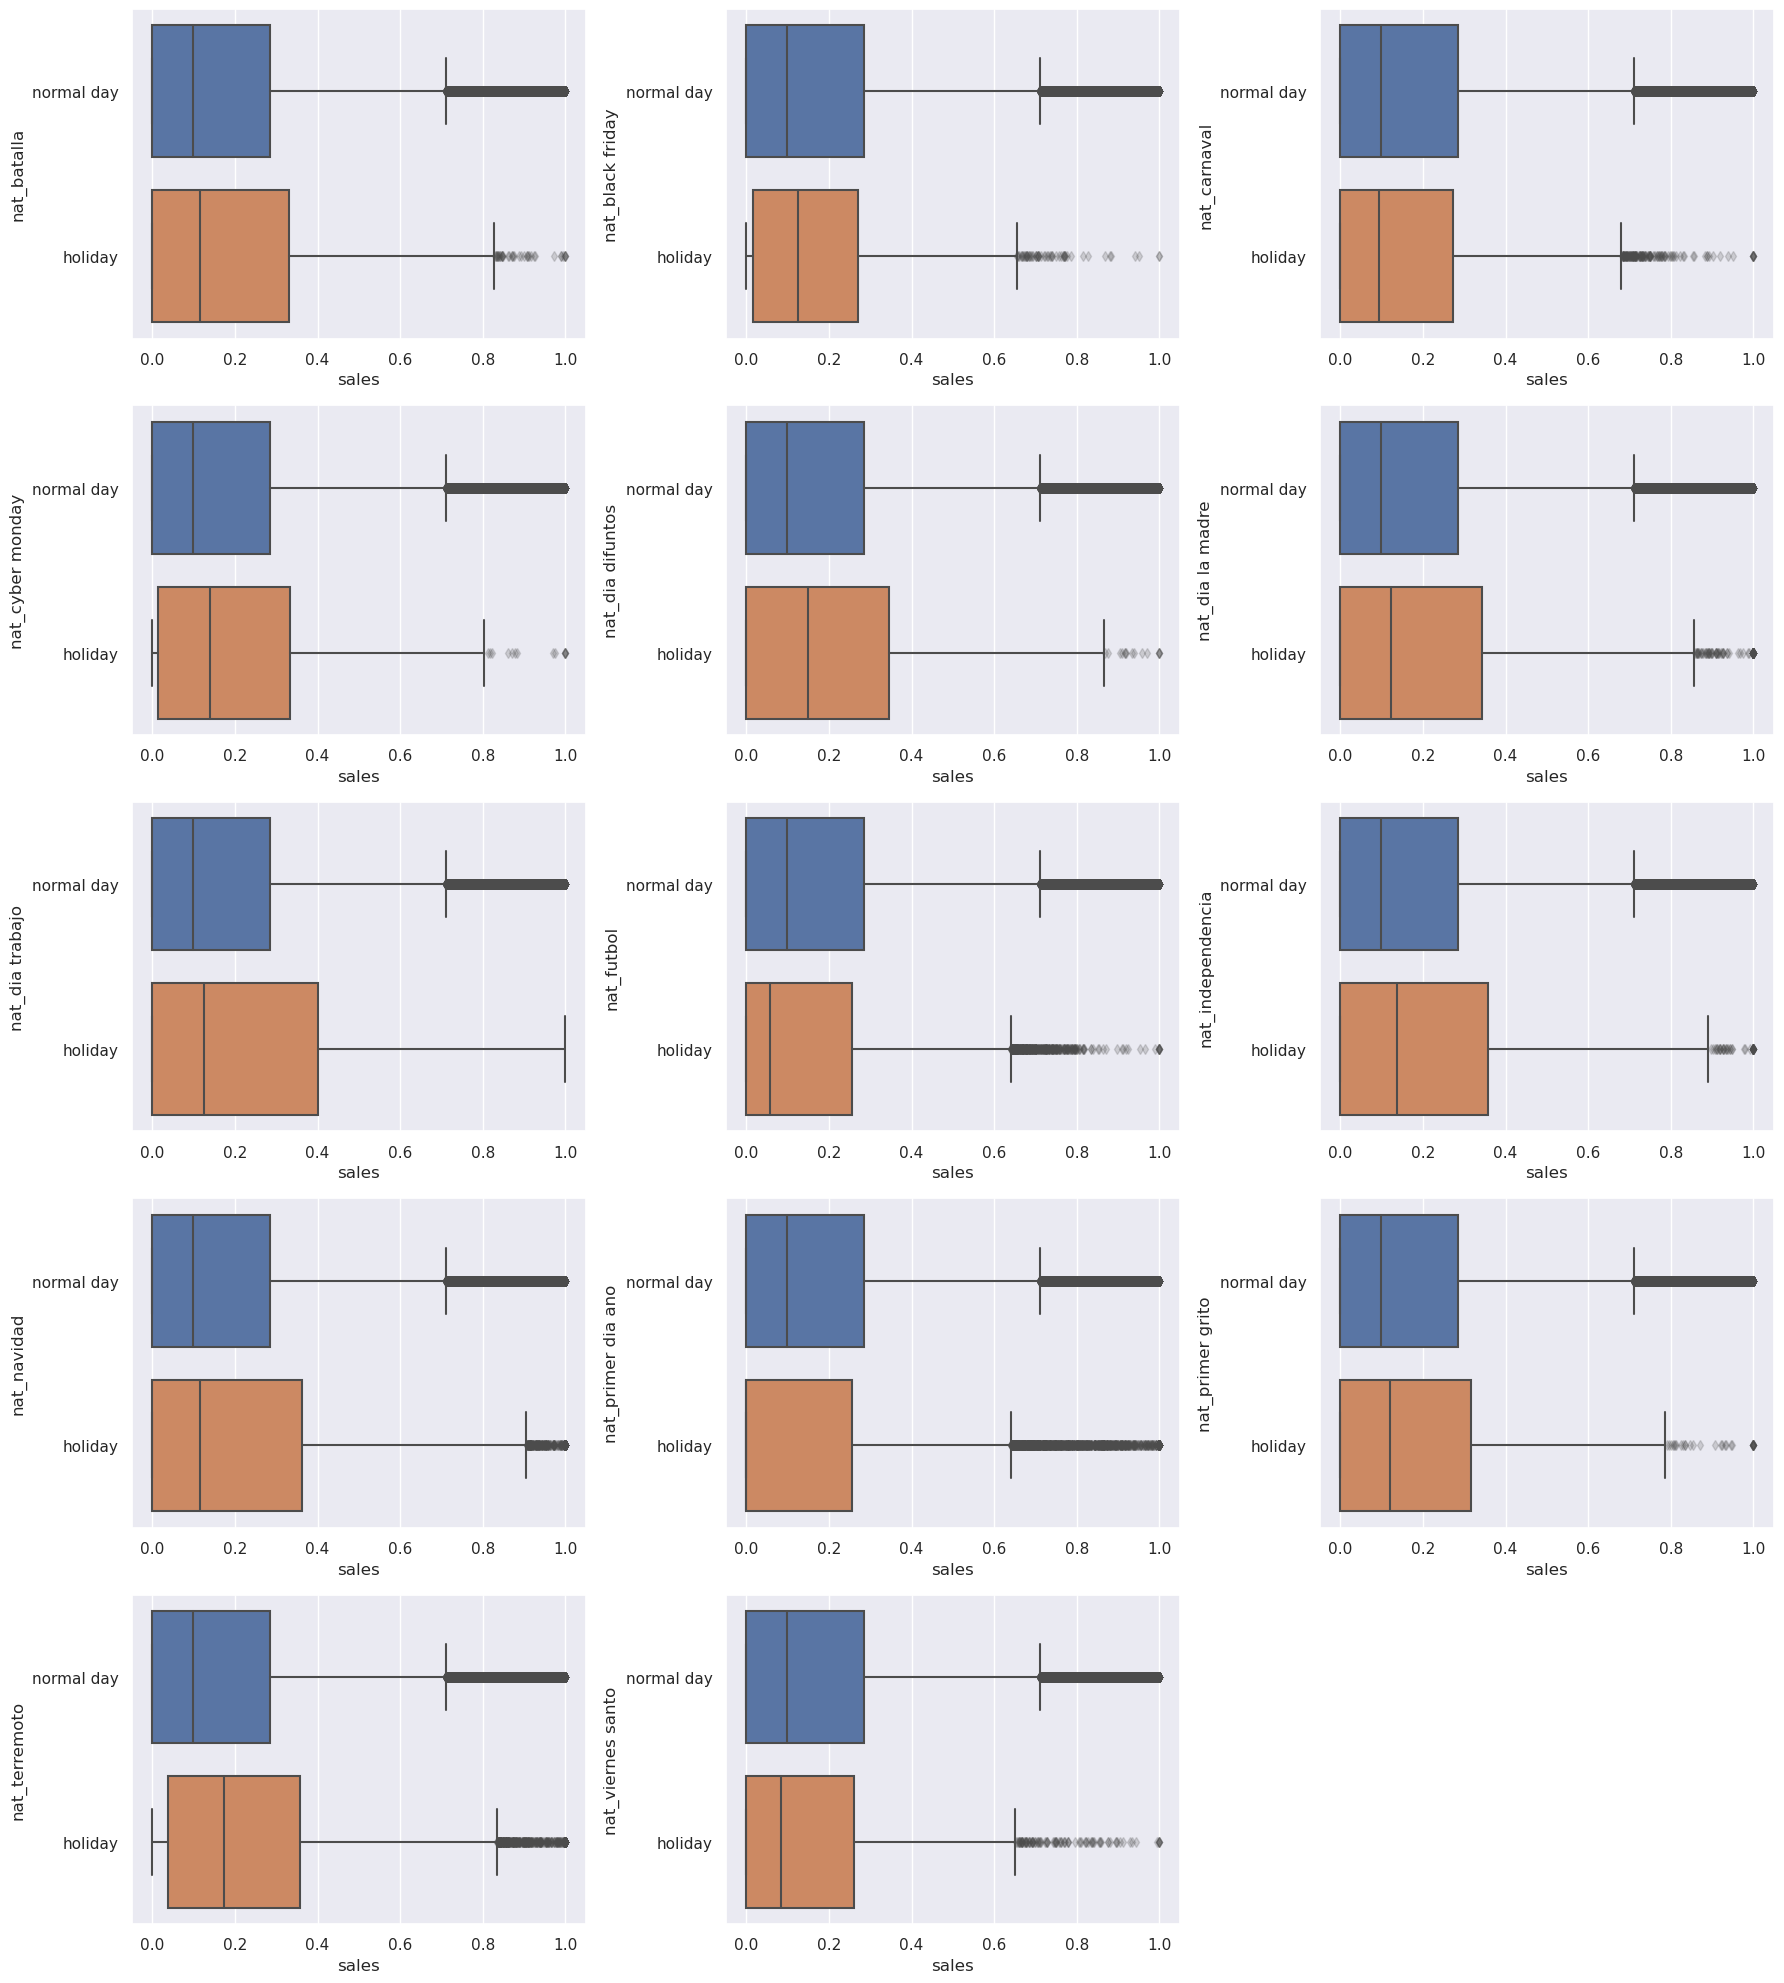

In [134]:
def plot_national_holiday_distribution():
    df = holiday_sales_merged.copy()    
    holiday_list = national_holidays.columns[1:]  
    
    plot_kwargs = {
        "flierprops": {"alpha": 0.2},
        "orient": "h"
    }
    
    fig = plt.figure(figsize=(18, 20))
    for j, hol in enumerate(holiday_list):
        sns.boxplot(
            data=df[(df[hol].eq(1)) | (df.no_holiday.eq(1))],
            y=hol,
            x="sales",
            ax=fig.add_subplot(5, 3, j+1),
            **plot_kwargs,
        )
        plt.yticks([0, 1], ["normal day", "holiday"])   
    plt.tight_layout()
    plt.show()

plot_national_holiday_distribution()

As we can see holidays which contribute significantly to sales are "nat_terremoto, nat_navidad, nat_dia la madre, nat_dia trabajo, nat_primer dia ano, nat_futbol, nat_dia difuntos". Let's keep them

**3.5 Merge data**

In [135]:
# keep selected national holidays with larger impacts on sales
selected_holidays = ["nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos"]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

data = pd.concat(
    [train_data, test_data], axis=0, ignore_index=True,
).merge(
    stores_data, on=["store_nbr"]
).merge(
    oil_data, on=["date"], how="left"
).merge(
    transactions_data, on=["date", 'store_nbr'], how="left"
).merge(
    work_days, on="date", how="left",    
).merge(
    keep_national_holidays, on=["date"],how="left").sort_values(["date", "store_nbr", "family"], ignore_index=True)

data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

**3.6 Date**

In [136]:
## Select the date, days of the week, hours, month  !not used in calculations
data['day_of_week'] = data.date.dt.dayofweek
data['day_of_year'] = data.date.dt.dayofyear
data['day_of_month'] = data.date.dt.day
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
#seasons 0-winter;1-spring;2-summer;3-fall
data["season"] = np.where(data.date.dt.month.isin([12,1,2]), 0, 1)
data["season"] = np.where(data.date.dt.month.isin([3,4,5]), 1, data["season"])
data["season"] = np.where(data.date.dt.month.isin([6,7,8]), 2, data["season"])
data["season"] = np.where(data.date.dt.month.isin([9, 10, 11]), 3, data["season"])
data.head()

date  store_nbr      family   id  sales  onpromotion  test   city  \
0 2013-01-01          1  AUTOMOTIVE 0.00   0.00         0.00     0  Quito   
1 2013-01-01          1   BABY CARE 1.00   0.00         0.00     0  Quito   
2 2013-01-01          1      BEAUTY 2.00   0.00         0.00     0  Quito   
3 2013-01-01          1   BEVERAGES 3.00   0.00         0.00     0  Quito   
4 2013-01-01          1       BOOKS 4.00   0.00         0.00     0  Quito   

       state type  cluster  dcoilwtico  transactions  work_day  nat_terremoto  \
0  Pichincha    D       13       93.14          0.00      0.00           0.00   
1  Pichincha    D       13       93.14          0.00      0.00           0.00   
2  Pichincha    D       13       93.14          0.00      0.00           0.00   
3  Pichincha    D       13       93.14          0.00      0.00           0.00   
4  Pichincha    D       13       93.14          0.00      0.00           0.00   

   nat_navidad  nat_dia la madre  nat_dia trabajo  nat_primer dia ano  \
0         0.00              0.00             0.00                1.00   
1         0.00              0.00             0.00                1.00   
2         0.00              0.00             0.00                1.00   
3         0.00              0.00             0.00                1.00   
4         0.00              0.00             0.00                1.00   

   nat_futbol  nat_dia difuntos  day_of_week  day_of_year  day_of_month  year  \
0        0.00              0.00            1            1             1  2013   
1        0.00              0.00            1            1             1  2013   
2        0.00              0.00            1            1             1  2013   
3        0.00              0.00            1            1             1  2013   
4        0.00              0.00            1            1             1  2013   

   month  season  
0      1       0  
1      1       0  
2      1       0  
3      1       0  
4      1       0

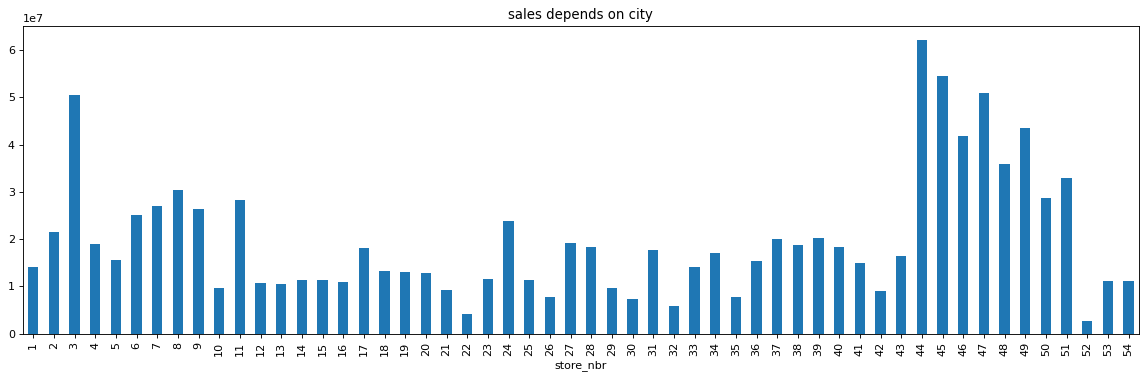

In [28]:
plt.figure(figsize=(18, 5), dpi= 80)

sales_city = data.groupby(['store_nbr'])['sales'].sum()
sales_city.plot.bar()
plt.title ("sales depends on store")
plt.show()

As we can see, sales across stores are distributed unevenly, but capacity does not allow us to examine all stores, so we will consider only a part of the stores

In [137]:
#Let's keep data for 1-20 stores, due to the lack of memory
data = data.loc[data['store_nbr'].isin(list(range(1, 19)))]

# 4. EDA (Exploratory Data Analysis)

In [138]:
train = data.loc[data['test'] == 0]
test = data.loc[data['test'] == 1]

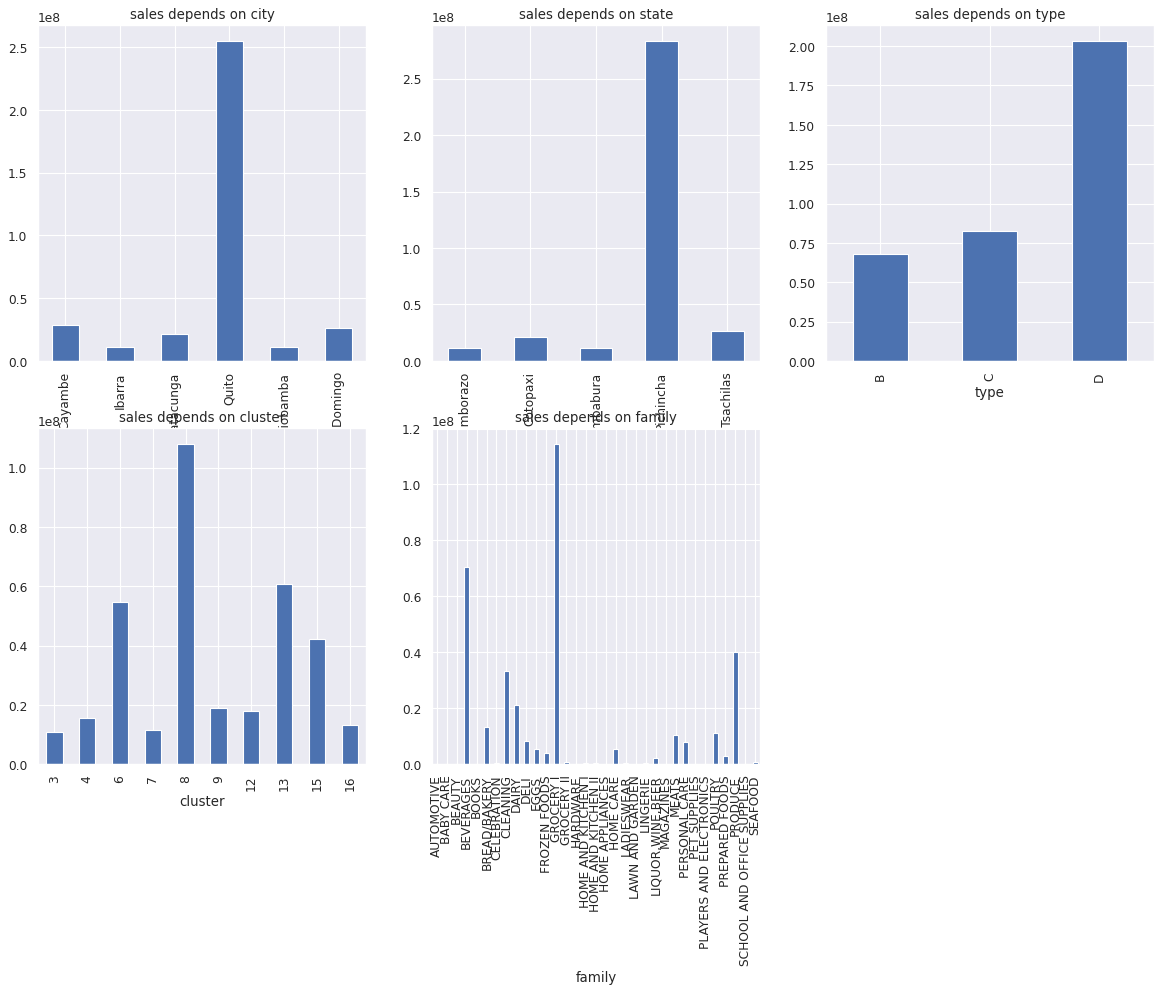

In [139]:
plt.figure(figsize=(18, 12), dpi= 80)

plt.subplot (2, 3, 1)
sales_city = train.groupby(['city'])['sales'].sum()
sales_city.plot.bar()
plt.title ("sales depends on city")

plt.subplot (2, 3, 2)
sales_state = train.groupby(['state'])['sales'].sum()
sales_state.plot.bar()
plt.title ("sales depends on state")

plt.subplot (2, 3, 3)
sales_type = train.groupby(['type'])['sales'].sum()
sales_type.plot.bar()
plt.title ("sales depends on type")

plt.subplot (2, 3, 4)
sales_cluster = train.groupby(['cluster'])['sales'].sum()
sales_cluster.plot.bar()
plt.title ("sales depends on cluster")

plt.subplot (2, 3, 5)
sales_type_y = train.groupby(['family'])['sales'].sum()
sales_type_y.plot.bar()
plt.title ("sales depends on family")
plt.show()

sales depend on the types of stores, so we conclude that we need these features

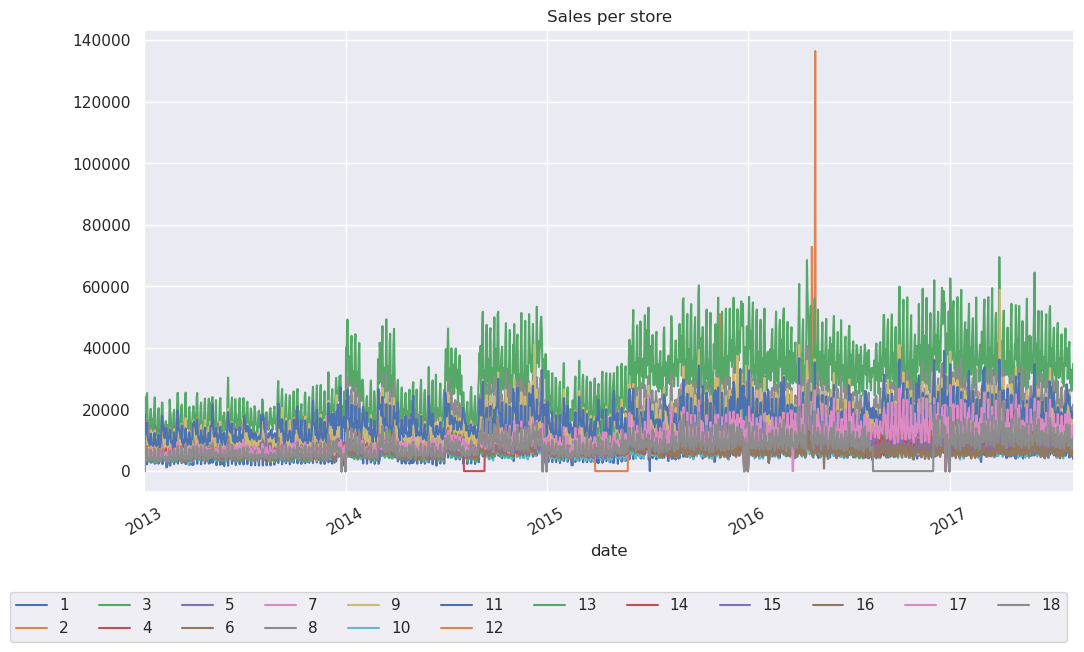

In [140]:
sale_store = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
sale_store = sale_store.pivot(index='date', columns='store_nbr', values='sales')
sale_store.plot(figsize=(12, 6))
plt.title("Sales per store", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=12)
plt.show()

on the chart we can observe a point with abnormal sales in 2016 for the certain stores

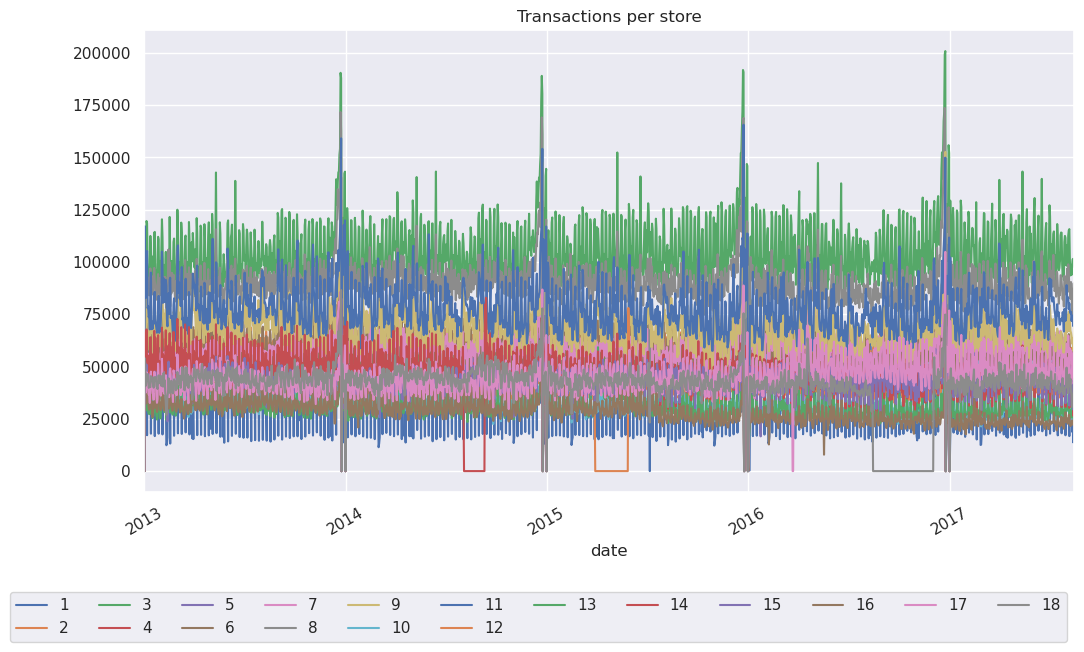

In [141]:
tr_store = train.groupby(['date','store_nbr'], as_index=False)['transactions'].sum()
tr_store = tr_store.pivot(index='date', columns='store_nbr', values='transactions')
tr_store.plot(figsize=(12, 6))
plt.title("Transactions per store", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=12) 
plt.show()

no anomalies are observed on the chart with transactions

**Family**

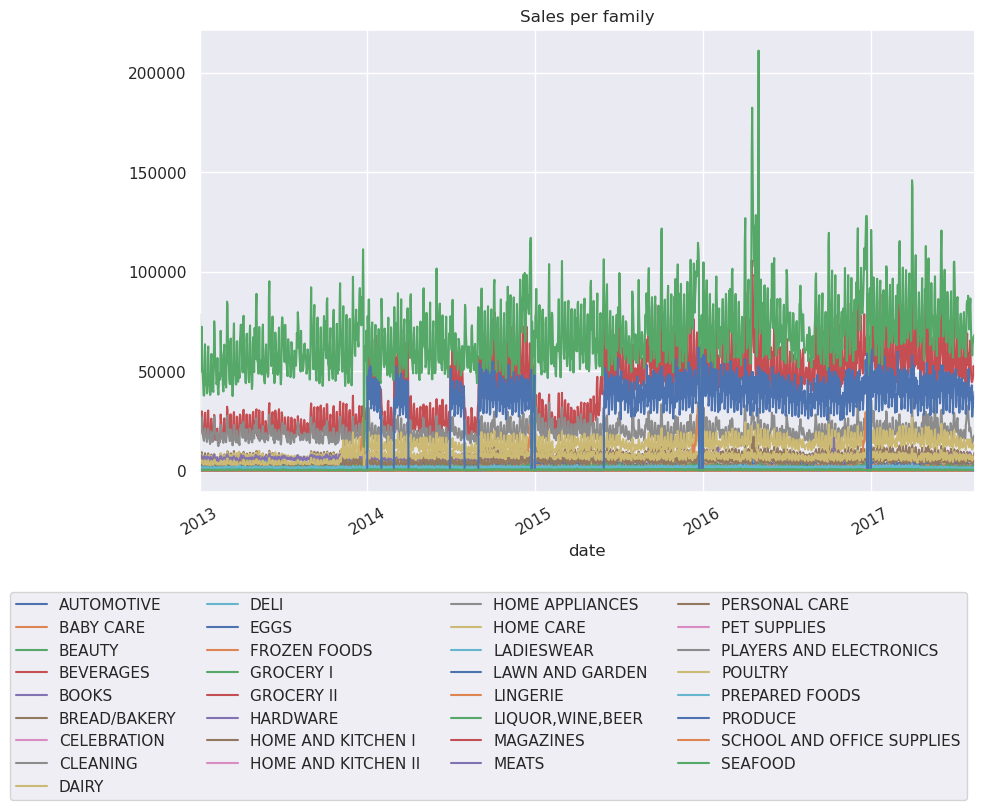

In [142]:
### Let's build average target curves by hours for each day of the week
sale_family = train.groupby(['date','family'], as_index=False)['sales'].sum()
sale_family = sale_family.pivot(index='date', columns='family', values='sales')
sale_family.plot(figsize=(10, 6))
plt.title("Sales per family", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=4)
plt.show()

**Timeline Sales**

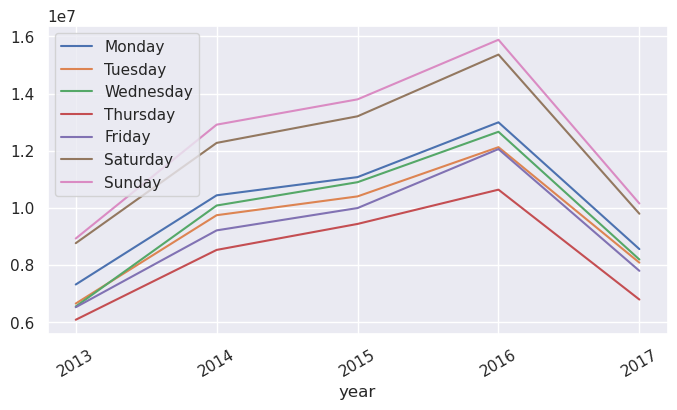

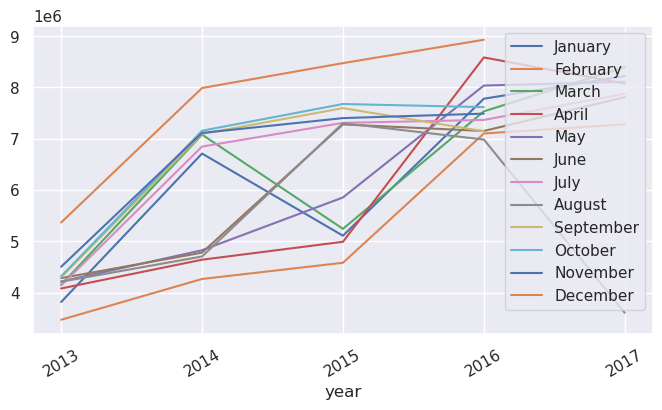

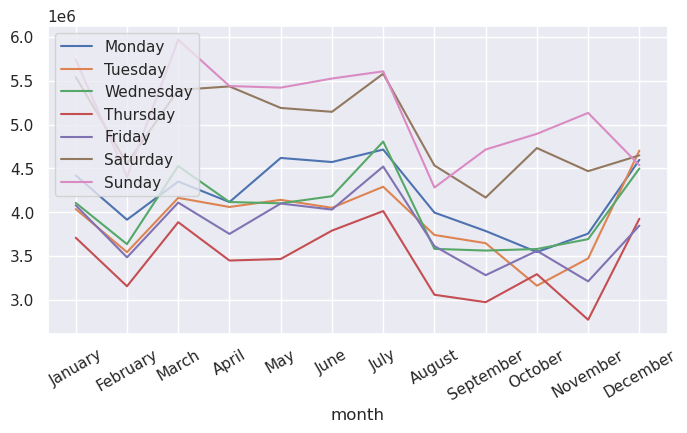

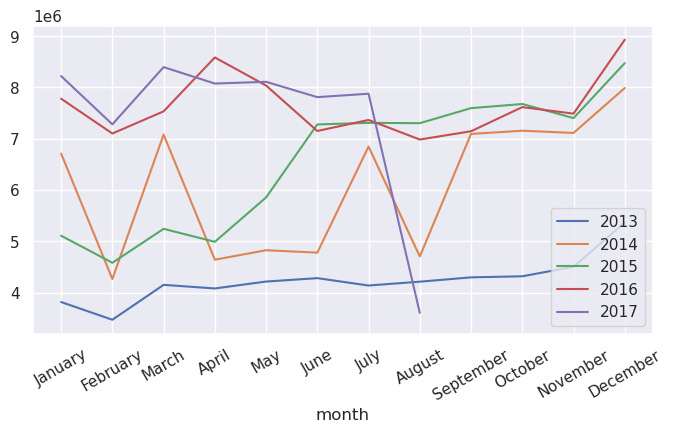

In [143]:
list_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
list_months = ['January','February','March','April','May','June','July','August','September','October','November','December'] 
list_years = ['2013','2014','2015','2016','2017']

frame1 = train.groupby(['day_of_week', 'year'], as_index=False)['sales'].sum()
frame1 = frame1.pivot(index='year', columns='day_of_week', values='sales')
frame1.plot(figsize=(8, 4))
plt.xticks(range(2013,2018,1),rotation=30)
plt.legend(list_days)

frame4 = train.groupby(['month', 'year'], as_index=False)['sales'].sum()
frame4 = frame4.pivot(index='year', columns='month', values='sales')
frame4.plot(figsize=(8, 4))
plt.xticks(range(2013,2018,1),rotation=30)
plt.legend(list_months)

frame2 = train.groupby(['day_of_week', 'month'], as_index=False)['sales'].sum()
frame2 = frame2.pivot(index='month', columns='day_of_week', values='sales')
frame2.plot(figsize=(8, 4))
plt.xticks(range(1,13), labels=list_months,rotation=30)
plt.legend(list_days)

frame3 = train.groupby(['month', 'year'], as_index=False)['sales'].sum()
frame3 = frame3.pivot(index='month', columns='year', values='sales')
frame3.plot(figsize=(8, 4))
plt.xticks(range(1,13), labels=list_months, rotation=30)
plt.legend(list_years)


plt.show()

* we can notice that sales from year to year during the week maintain their trends and there is a gradual increase
* by month the dependence is less obvious but there is an increasing trend
* the last two graphs do not allow us to draw any meaningful conclusions

**What products are affected by discounts?**

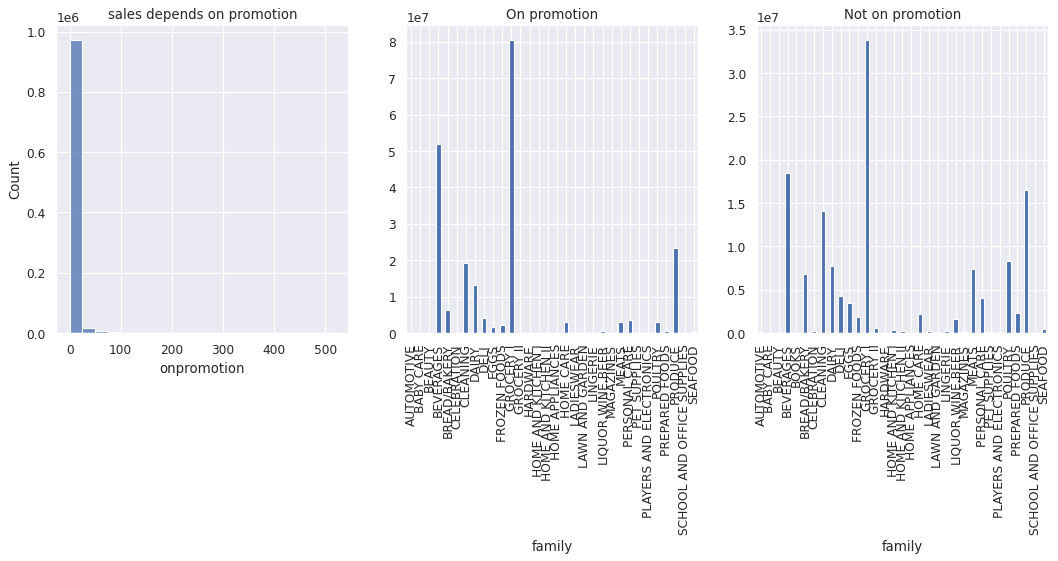

In [144]:
plt.figure(figsize=(16, 5), dpi= 80)

plt.subplot (1, 3, 1)
sns.histplot(data=train, x='onpromotion')
plt.title ("sales depends on promotion")

plt.subplot (1, 3, 2)
data_promo_yes = train.copy()
data_promo_yes = data_promo_yes[data_promo_yes['onpromotion']!=0]
data_promo_yes = data_promo_yes.groupby(['family'])['sales'].sum()
data_promo_yes.plot.bar()
plt.title ("On promotion")

plt.subplot (1, 3, 3)
data_promo_no = train.copy()
data_promo_no = data_promo_no[data_promo_no['onpromotion']==0]
data_promo_no = data_promo_no.groupby(['family'])['sales'].sum()
data_promo_no.plot.bar()
plt.title ("Not on promotion")

plt.show()

As we can see, for many categories of goods, demand increases depending on whether it participates in promotions

**Correlation of oil prices and sales/promotions/transactions**

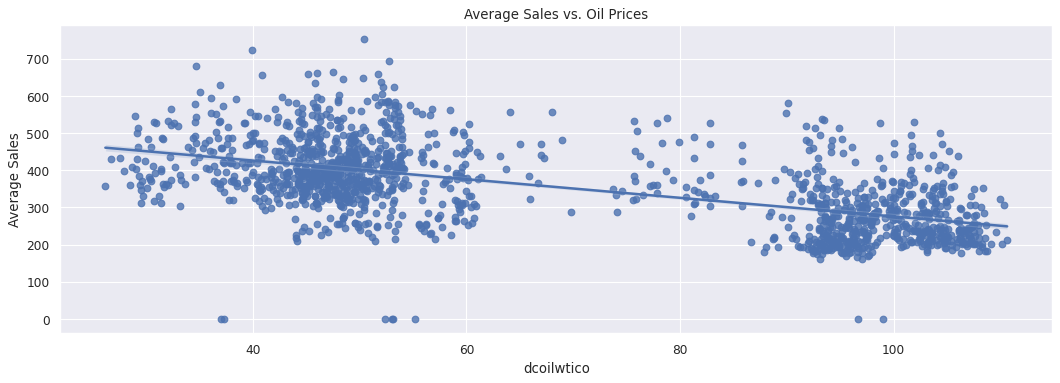

In [145]:
data_sales_oil = train.copy()
data_sales_oil = data_sales_oil.groupby(['dcoilwtico'], as_index=False)['sales'].mean()

plt.figure(figsize=(16, 5), dpi= 80)
sns.regplot(x=data_sales_oil.dcoilwtico, y=data_sales_oil.sales)
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Oil Prices")
plt.show()

we can notice that the more expensive oil is, the fewer sales

Text(0.5, 1.0, 'Average Sales vs. Store Transactions')

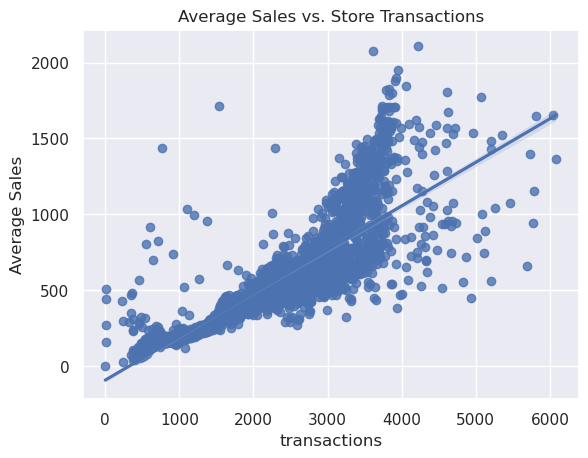

In [146]:
data_sales_tr = train.copy()
data_sales_tr = data_sales_tr.groupby(['transactions'], as_index=False)['sales'].mean()

sns.regplot(x=data_sales_tr.transactions, y=data_sales_tr.sales)
plt.xlabel("transactions")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Store Transactions")

you can see that the number of sales increases with the number of transactions, which is quite expected

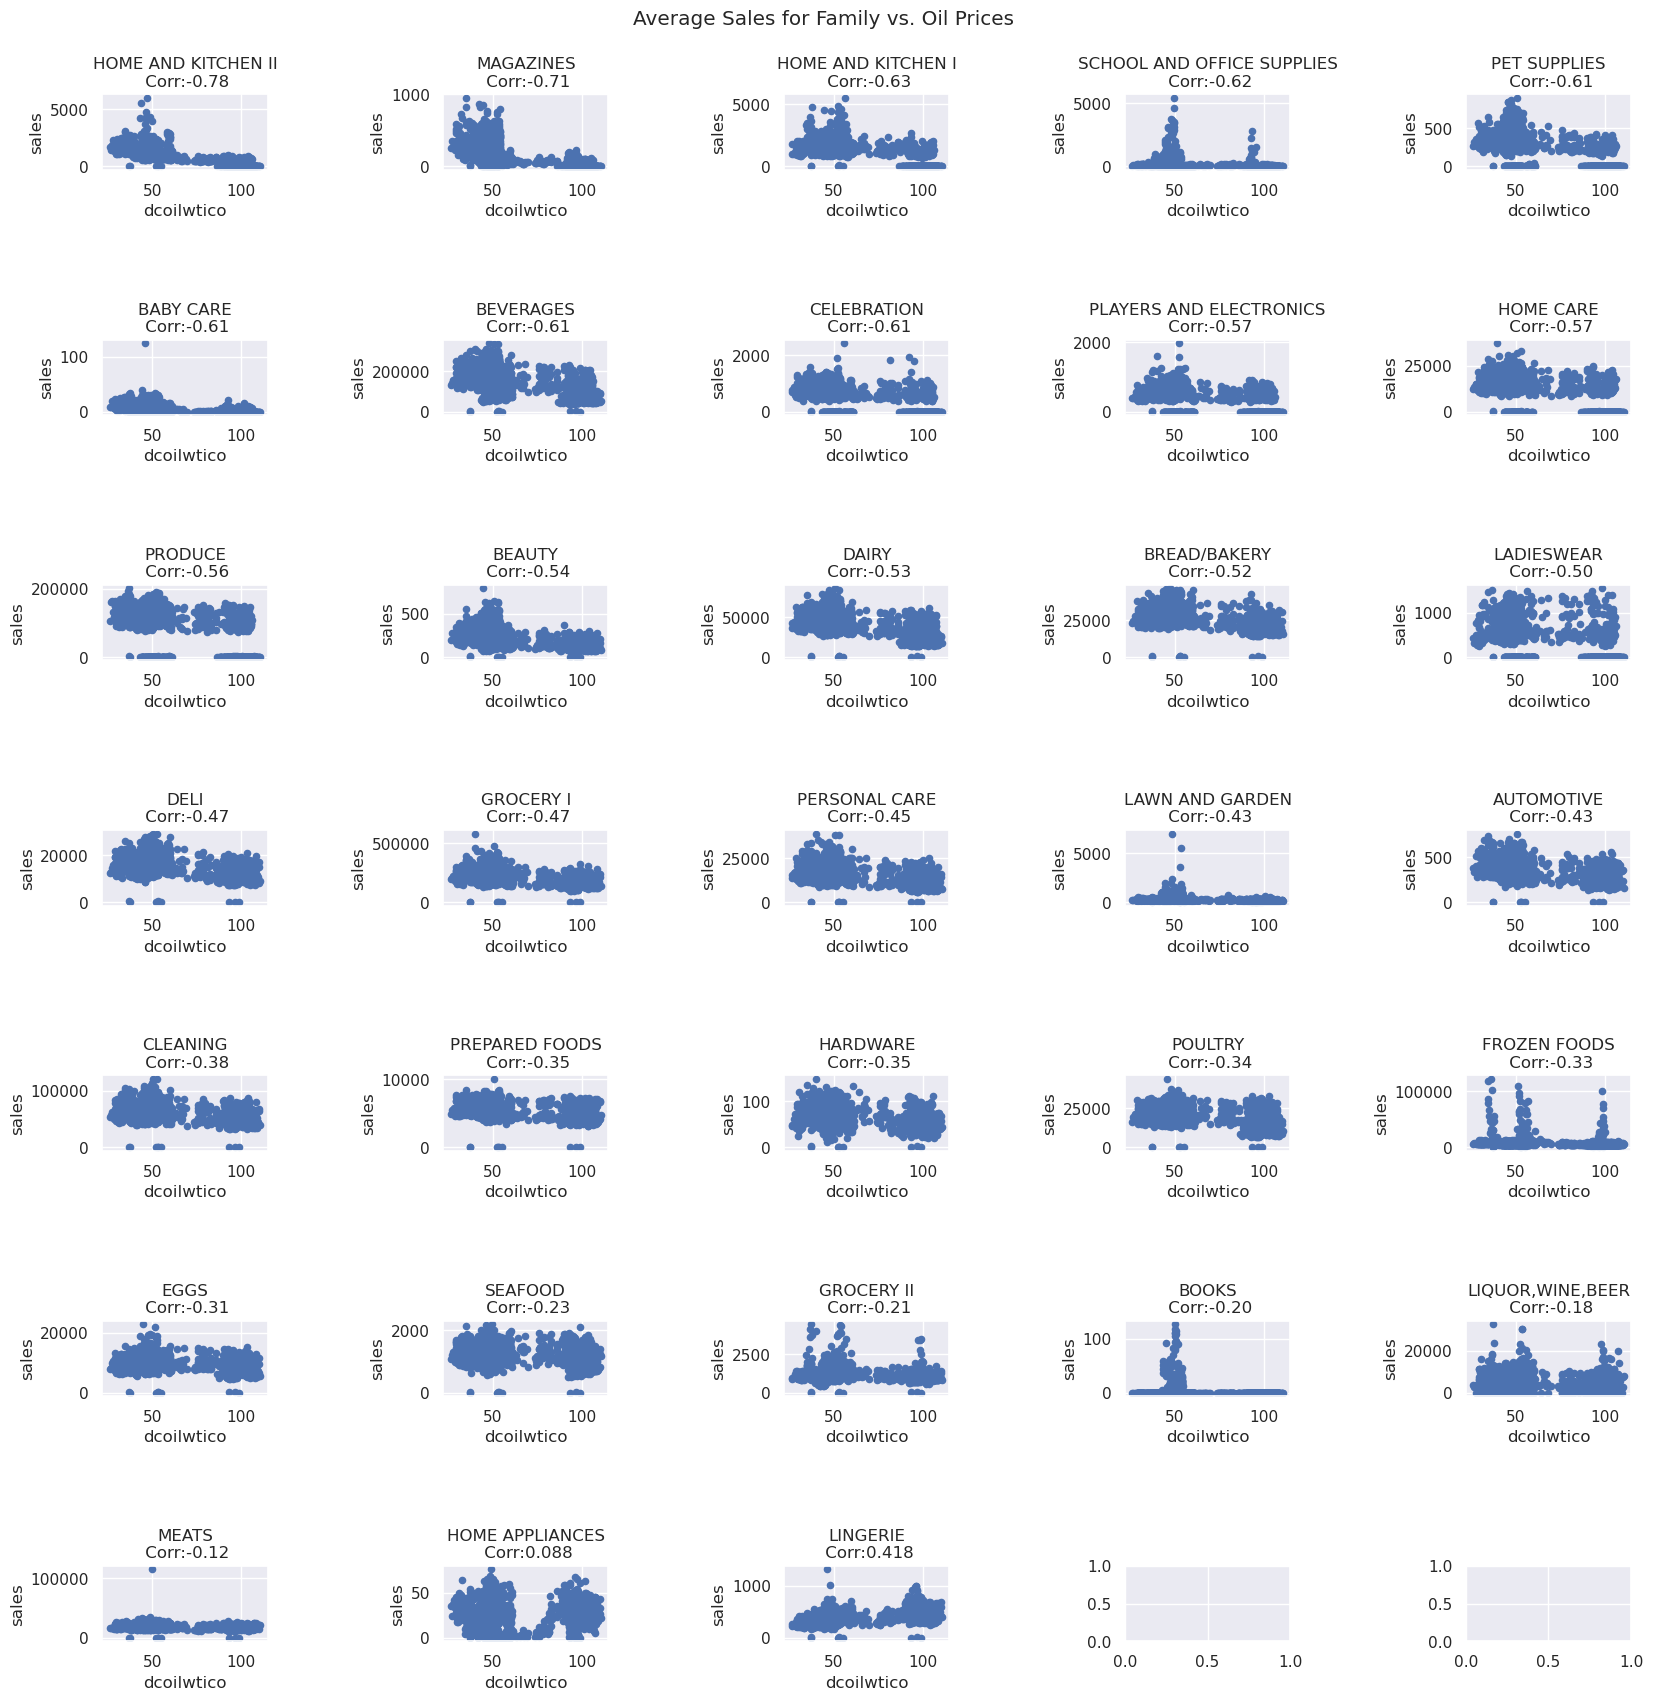

In [147]:
df_train_oil = pd.merge(train_data.groupby(["date", "family"])['sales'].sum().reset_index(),
             oil_data, how="left")
corr_train_oil = df_train_oil.groupby("family").corr("spearman").reset_index()
corr_train_oil = corr_train_oil[corr_train_oil[
    'level_1'] == "dcoilwtico"][["family", "sales"]].sort_values("sales")
    
fig, axes = plt.subplots(7, 5, figsize=(18, 18))
for i, j in enumerate(corr_train_oil['family']):
    df_train_oil[df_train_oil['family'] == j].plot.scatter(x="dcoilwtico", y="sales", ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(j + "\n Corr:" + str(
        corr_train_oil[corr_train_oil.family == j].sales.iloc[0])[:5])

plt.tight_layout(pad=5)
plt.suptitle("Average Sales for Family vs. Oil Prices \n")
plt.show()


we can notice that the dependence of different types of goods on oil varies greatly, which means this is an important feature

**Seasonality**

In [148]:
data_seasons = train.copy()
data_winter = data_seasons[data_seasons['season']==0]
data_spring = data_seasons[data_seasons['season']==1]
data_summer = data_seasons[data_seasons['season']==2]
data_fall = data_seasons[data_seasons['season']==3]

sales_family_winter = data_winter.groupby(['family'])['sales'].sum().reset_index()
sales_family_spring = data_spring.groupby(['family'])['sales'].sum().reset_index()
sales_family_summer = data_summer.groupby(['family'])['sales'].sum().reset_index()
sales_family_fall = data_fall.groupby(['family'])['sales'].sum().reset_index()

sales_family_winter = sales_family_winter.rename(columns = {"sales": "sales_winter"})
sales_family_spring = sales_family_spring.rename(columns = {"sales": "sales_spring"})
sales_family_summer = sales_family_summer.rename(columns = {"sales": "sales_summer"})
sales_family_fall = sales_family_fall.rename(columns = {"sales": "sales_fall"})

df_all_seasons = sales_family_winter.merge(
    sales_family_spring, on=["family"]).merge(
    sales_family_summer, on=["family"]).merge(
    sales_family_fall, on=["family"])

df_all_seasons.head()

family  sales_winter  sales_spring  sales_summer  sales_fall
0  AUTOMOTIVE      41574.00      45796.00      43230.00    34774.00
1   BABY CARE       1001.00       1114.00       1489.00     1060.00
2      BEAUTY      26919.00      27728.00      29905.00    23689.00
3   BEVERAGES   17366197.00   18216018.00   18207011.00 16561615.00
4       BOOKS        771.00        291.00         41.00      987.00

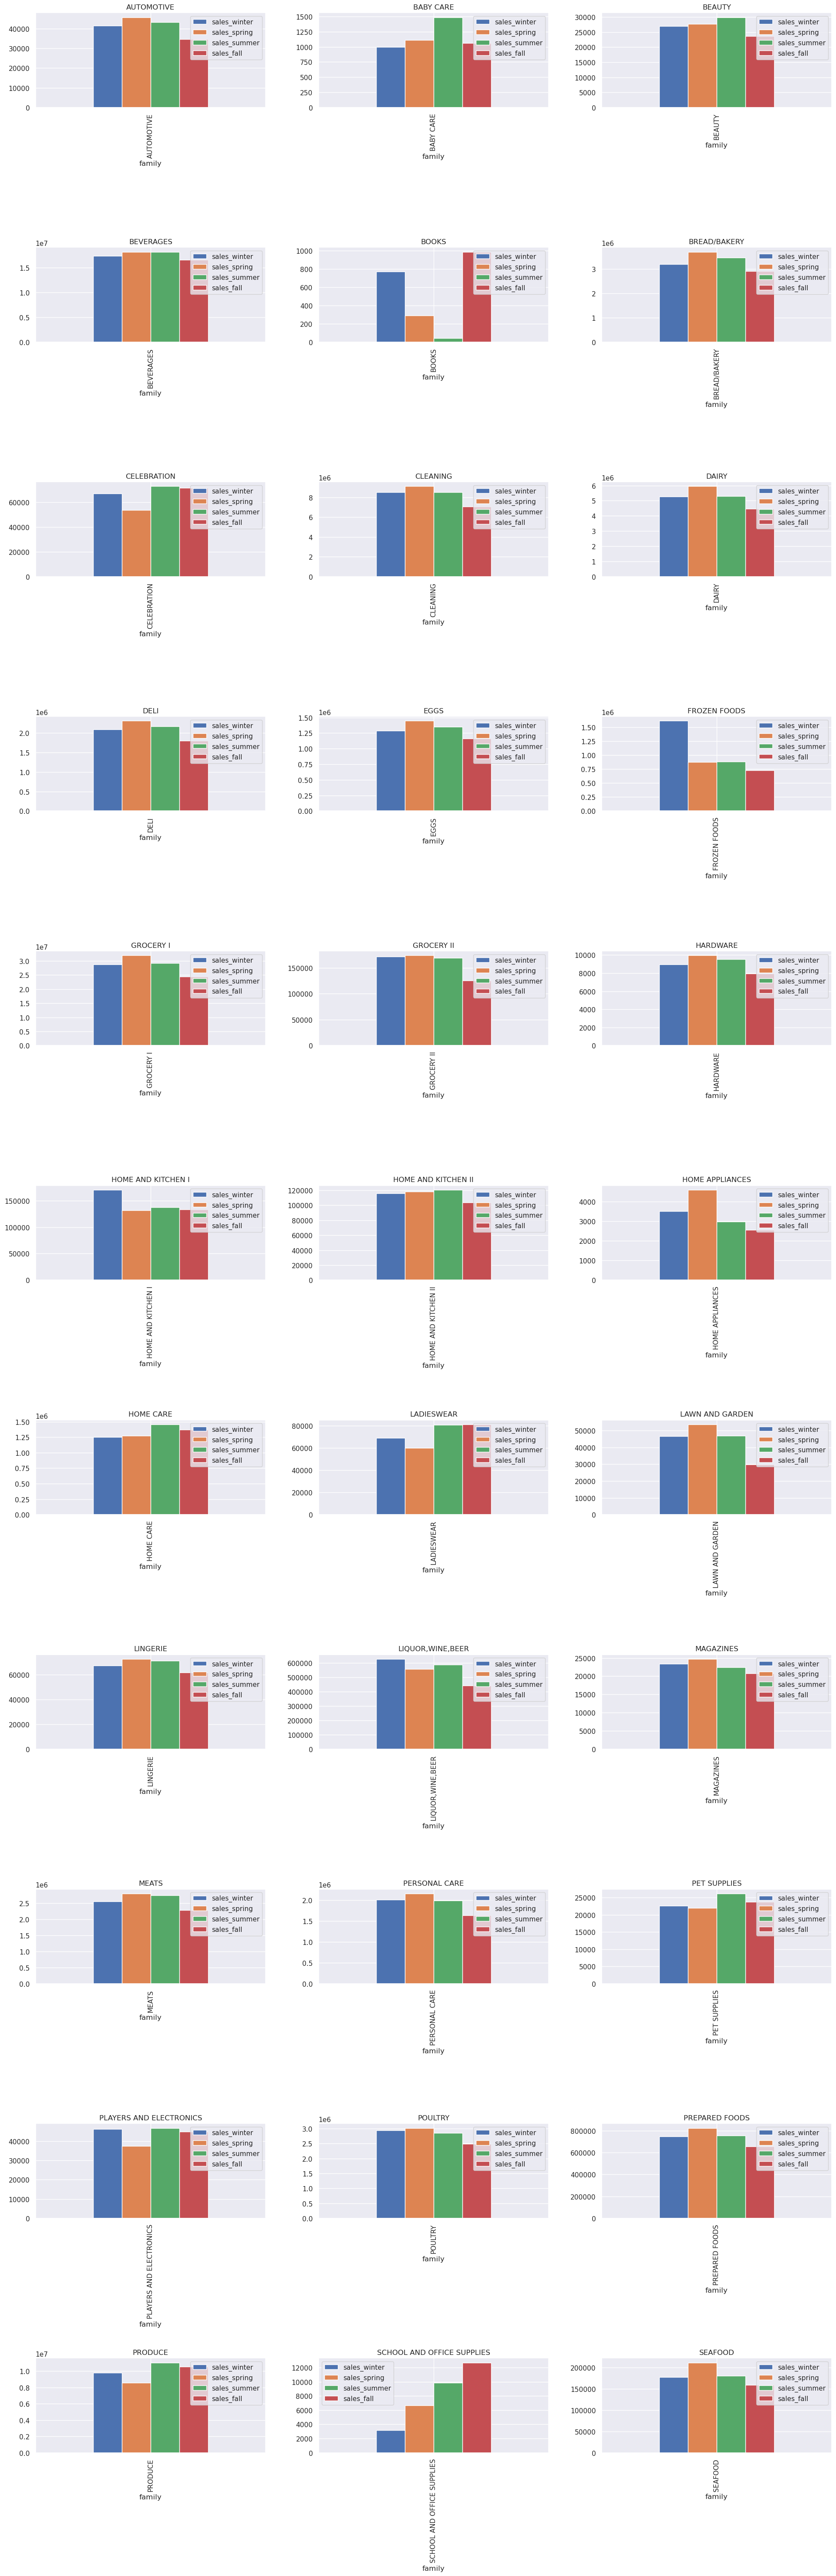

In [149]:
# plot data in grouped manner of bar type
fig, axes = plt.subplots(11, 3, figsize=(20, 60))
for i, j in enumerate(df_all_seasons['family']):
    df_all_seasons[df_all_seasons['family'] == j].plot(
        x='family', kind='bar',stacked=False,ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(j)

plt.tight_layout(pad=3)
plt.show()


* we can observe how sales of different categories of goods change depending on the season, on the basis of which we can conclude that this is an important feature

**Promotions**

Text(0.5, 1.0, 'Average Sales vs. Promotions')

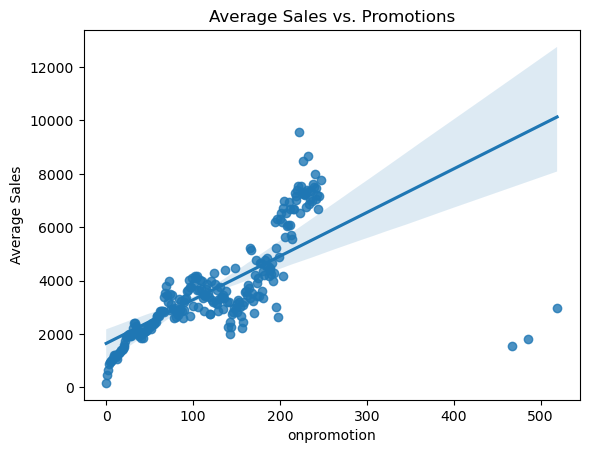

In [43]:
data_sales_prom = train.copy()
data_sales_prom = data_sales_prom.groupby(['onpromotion'], as_index=False)['sales'].mean()

sns.regplot(x=data_sales_prom.onpromotion, y=data_sales_prom.sales)
plt.xlabel("onpromotion")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Promotions")

We can observe an increase in sales with an increase in the number of products on promotions

In [45]:
del data_sales_prom,df_all_seasons,sales_family_winter,sales_family_spring,sales_family_summer,sales_family_fall,data_winter,data_spring,data_summer,data_fall

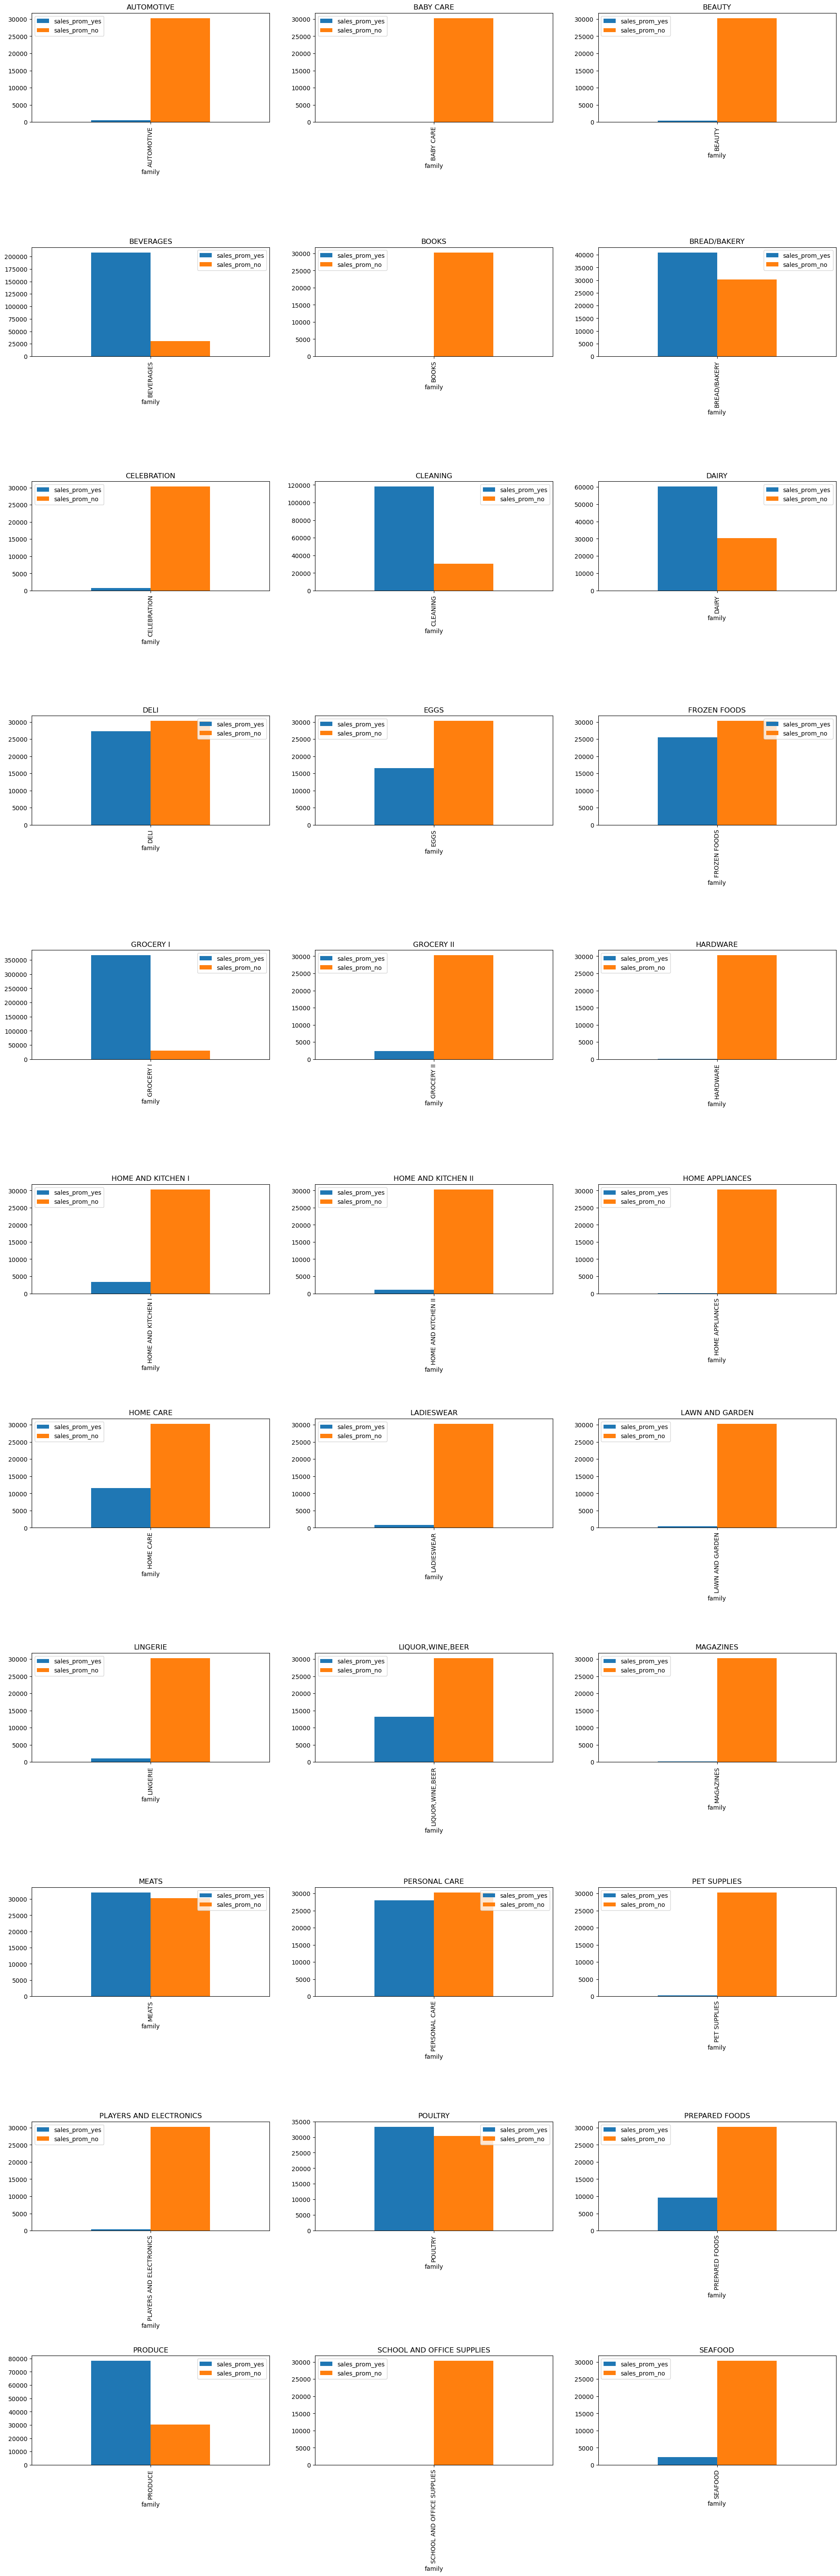

In [46]:
data_prom = train.copy()
data_prom_yes = data_prom[data_prom['work_day']!=0]
data_prom_yes_sum = data_prom_yes.groupby([
    'family'])['sales'].sum().reset_index().rename(columns = {"sales": "sales_prom_yes"})

data_prom_no = data_prom[data_prom['work_day']==0]
data_prom_no_sum = data_prom_no.groupby([
    'family'])['sales'].count().reset_index().rename(columns = {"sales": "sales_prom_no"})

df_prom = data_prom_yes_sum.merge(data_prom_no_sum, on=["family"])

fig, axes = plt.subplots(11, 3, figsize=(20, 60))

for i, j in enumerate(df_prom['family']):
    df_prom[df_prom['family'] == j].plot(x='family', kind='bar',stacked=False,
                                         ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(j)

plt.tight_layout(pad=3)
plt.show()

We can observe an increase in sales with an increase in the number of products on promotions

In [47]:
del data_prom, data_prom_yes, data_prom_yes_sum, data_prom_no, data_prom_no_sum, df_prom

**Analyze Outliers in the Data**

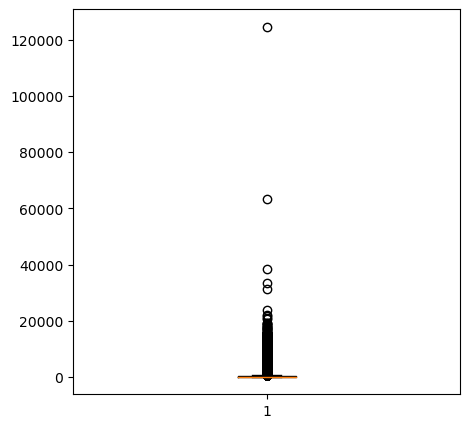

In [48]:
fig = plt.figure()
fig.set_size_inches((5, 5))
plt.boxplot(train['sales'].values)

plt.show()

we may notice that there are outliers in the data, but we deliberately exclude them

**heatmap with correlation matrix**

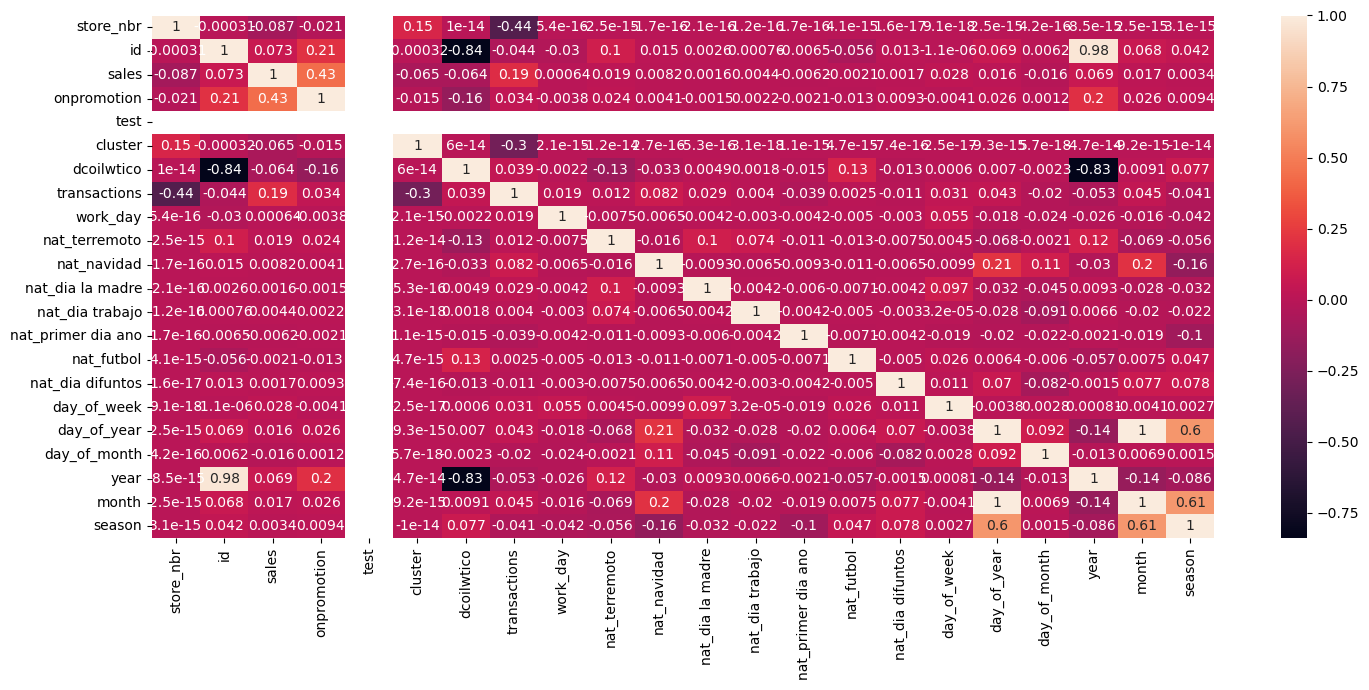

In [49]:
plt.figure(figsize=(15,7))
sns.heatmap(train.corr(),annot=True)
plt.tight_layout()

We can notice that the signs are weakly correlated

In [51]:
data_analyses = data.copy()

target = 'sales'
train = data_analyses.loc[data_analyses['test'] == 0]
test = data_analyses.loc[data_analyses['test'] == 1]

**Hypothesis Testing**

let's write a function that will help us understand whether the groups are similar to create an additional feature

T Test
1. Normality Test: Shapiro Test
2. Homogeneity Test: Levene Test
3. Parametric or Non-Parametric T Test: T-Test, Welch Test, Mann Whitney U

In [52]:
def CompareTwoGroups(dataframe, group, target):
    # Create Combinations
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))
    AB = pd.DataFrame()
    for i in range(0, len(item_comb)):
        # Define Groups
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]
        # Assumption: Normality
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is Normal! - False
        # H1: Distribution is not Normal! - True
        if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
            # Parametric Test
            # Assumption: Homogeneity of variances
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True
            if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
            else:
                # Heterogeneous
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(groupA, groupB)[1] 
            # H0: M1 = M2 - False
            # H1: M1 != M2 - True
            
        temp = pd.DataFrame({"Compare Two Groups":[ttest < 0.05], 
                             "p-value":[ttest],
                             "GroupA_Mean":[groupA.mean()], 
                             "GroupB_Mean":[groupB.mean()],
                             "GroupA_Median":[groupA.median()], 
                             "GroupB_Median":[groupB.median()],
                             "GroupA_Count":[groupA.count()], 
                             "GroupB_Count":[groupB.count()]}, index = [item_comb[i]])
        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"] == True, 
                                              "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
        
        AB = pd.concat([AB, temp[["TestType", "Compare Two Groups", 
                                  "p-value","GroupA_Median", "GroupB_Median",
                                  "GroupA_Mean", "GroupB_Mean",
                                  "GroupA_Count", "GroupB_Count"]]])   
    return AB

CompareTwoGroups(train, group = "store_nbr", target = "sales")

TestType Compare Two Groups  p-value  GroupA_Median  \
(1, 2)    Non-Parametric   Different Groups     0.00          18.55   
(1, 3)    Non-Parametric   Different Groups     0.00          18.55   
(1, 4)    Non-Parametric   Different Groups     0.00          18.55   
(1, 5)    Non-Parametric   Different Groups     0.00          18.55   
(1, 6)    Non-Parametric   Different Groups     0.00          18.55   
...                  ...                ...      ...            ...   
(15, 17)  Non-Parametric   Different Groups     0.00           8.00   
(15, 18)  Non-Parametric     Similar Groups     0.39           8.00   
(16, 17)  Non-Parametric   Different Groups     0.00           6.00   
(16, 18)  Non-Parametric   Different Groups     0.00           6.00   
(17, 18)  Non-Parametric   Different Groups     0.00          10.00   

          GroupB_Median  GroupA_Mean  GroupB_Mean  GroupA_Count  GroupB_Count  
(1, 2)            23.00       253.93       387.00         55704         55704  
(1, 3)            63.00       253.93       906.25         55704         55704  
(1, 4)            19.00       253.93       339.47         55704         55704  
(1, 5)            19.00       253.93       279.92         55704         55704  
(1, 6)            28.00       253.93       452.10         55704         55704  
...                 ...          ...          ...           ...           ...  
(15, 17)          10.00       205.57       323.69         55704         55704  
(15, 18)           8.00       205.57       238.03         55704         55704  
(16, 17)          10.00       197.23       323.69         55704         55704  
(16, 18)           8.00       197.23       238.03         55704         55704  
(17, 18)           8.00       323.69       238.03         55704         55704  

[153 rows x 9 columns]

In [54]:
# Rolling Summary Stats Features
#A rolling mean is simply the mean of a certain number of previous periods in a time series.
for i in [16,17,18,19,20,21,22,46,76,106,365, 730]:
    data_analyses["sales_roll_mean_"+str(i)]=data_analyses.groupby(
        ["store_nbr", "family"])['sales'].rolling(i).mean().shift(1).values
    
# 2. Hypothesis Testing: Similarity
# Store Based
storesales = train.groupby(["date", "store_nbr"])['sales'].sum().reset_index()
ctg_ss = CompareTwoGroups(storesales, group="store_nbr", target="sales")
del storesales
#Let's find similar groups
ctg_ss[ctg_ss["Compare Two Groups"] == "Similar Groups"]

TestType Compare Two Groups  p-value  GroupA_Median  \
(12, 16)  Non-Parametric     Similar Groups     0.61        6386.87   
(14, 15)  Non-Parametric     Similar Groups     0.16        6529.03   

          GroupB_Median  GroupA_Mean  GroupB_Mean  GroupA_Count  GroupB_Count  
(12, 16)        6146.28      6314.70      6508.54          1688          1688  
(14, 15)        6826.27      6746.40      6783.93          1688          1688

As we can see, there were two pairs of similar stores (12,16) and (14,15) and we can create a special feature reflecting the similarity of the stores

In [55]:
data_analyses["StoreSalesSimilarity"] = np.where(data_analyses["store_nbr"].isin([12,16]), 1, 0)
data_analyses["StoreSalesSimilarity"] = np.where(data_analyses["store_nbr"].isin([14,15]), 2, data_analyses["StoreSalesSimilarity"])

#Now let's filter the results by similarity of groups when grouped by "family"
# Item Based
itemsales = train.groupby(["date", "family"])['sales'].sum().reset_index()
ctg_is = CompareTwoGroups(itemsales, group = "family", target = "sales")
del itemsales
ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]

TestType  \
(CELEBRATION, LINGERIE)                        Non-Parametric   
(GROCERY II, HOME AND KITCHEN I)               Non-Parametric   
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)  Non-Parametric   
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)     Non-Parametric   
(MAGAZINES, PET SUPPLIES)                      Non-Parametric   

                                              Compare Two Groups  p-value  \
(CELEBRATION, LINGERIE)                           Similar Groups     0.15   
(GROCERY II, HOME AND KITCHEN I)                  Similar Groups     0.87   
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)     Similar Groups     0.05   
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)        Similar Groups     0.26   
(MAGAZINES, PET SUPPLIES)                         Similar Groups     0.69   

                                               GroupA_Median  GroupB_Median  \
(CELEBRATION, LINGERIE)                               184.00         157.00   
(GROCERY II, HOME AND KITCHEN I)                      359.00         376.00   
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)           8.00           7.00   
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)             82.00         127.00   
(MAGAZINES, PET SUPPLIES)                              26.50          66.00   

                                               GroupA_Mean  GroupB_Mean  \
(CELEBRATION, LINGERIE)                             156.99       161.87   
(GROCERY II, HOME AND KITCHEN I)                    379.52       339.36   
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)         8.09        19.18   
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)          104.91       103.80   
(MAGAZINES, PET SUPPLIES)                            54.12        55.95   

                                               GroupA_Count  GroupB_Count  
(CELEBRATION, LINGERIE)                                1688          1688  
(GROCERY II, HOME AND KITCHEN I)                       1688          1688  
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)          1688          1688  
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)             1688          1688  
(MAGAZINES, PET SUPPLIES)                              1688          1688

As we can see, there were two pairs of similar family (CELEBRATION, LINGERIE),(GROCERY II, HOME AND KITCHEN I), (HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES), (LAWN AND GARDEN, PLAYERS AND ELECTRONICS), (MAGAZINES, PET SUPPLIES) and we can create a special feature reflecting the similarity of the family

In [56]:
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['CELEBRATION', 'LINGERIE']), 1, 0)
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['GROCERY II', 'HOME AND KITCHEN I']), 2, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['HOME APPLIANCES', 'SCHOOL AND OFFICE SUPPLIES']), 3, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS']), 4, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['MAGAZINES', 'PET SUPPLIES']), 5, data_analyses["ItemSalesSimilarity"])

**Lag/Shifted Features**

In [57]:
data_analyses.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)

In [58]:
def lag_features(dataframe, lags, groups = ["store_nbr", "family"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

#Let's create lags
data_analyses = lag_features(data_analyses, 
                             lags = [16,17,18,19,20,21,22,46,76,106,365, 730],
                             groups = ["store_nbr", "family"], target = 'sales', 
                             prefix = 'sales_lag_')
data_analyses

date  store_nbr      family         id  sales  onpromotion  \
0       2013-01-01          1  AUTOMOTIVE       0.00   0.00         0.00   
1782    2013-01-02          1  AUTOMOTIVE    1782.00   2.00         0.00   
3564    2013-01-03          1  AUTOMOTIVE    3564.00   3.00         0.00   
5346    2013-01-04          1  AUTOMOTIVE    5346.00   3.00         0.00   
7128    2013-01-05          1  AUTOMOTIVE    7128.00   5.00         0.00   
...            ...        ...         ...        ...    ...          ...   
3028211 2017-08-27         18     SEAFOOD 3020819.00    NaN         0.00   
3029993 2017-08-28         18     SEAFOOD 3022601.00    NaN         0.00   
3031775 2017-08-29         18     SEAFOOD 3024383.00    NaN         0.00   
3033557 2017-08-30         18     SEAFOOD 3026165.00    NaN         0.00   
3035339 2017-08-31         18     SEAFOOD 3027947.00    NaN         0.00   

         test   city      state type  cluster  dcoilwtico  transactions  \
0           0  Quito  Pichincha    D       13       93.14          0.00   
1782        0  Quito  Pichincha    D       13       93.14       2111.00   
3564        0  Quito  Pichincha    D       13       92.97       1833.00   
5346        0  Quito  Pichincha    D       13       93.12       1863.00   
7128        0  Quito  Pichincha    D       13       93.15       1509.00   
...       ...    ...        ...  ...      ...         ...           ...   
3028211     1  Quito  Pichincha    B       16       46.82           NaN   
3029993     1  Quito  Pichincha    B       16       46.40           NaN   
3031775     1  Quito  Pichincha    B       16       46.46           NaN   
3033557     1  Quito  Pichincha    B       16       45.96           NaN   
3035339     1  Quito  Pichincha    B       16       47.26           NaN   

         work_day  nat_terremoto  nat_navidad  nat_dia la madre  \
0            0.00           0.00         0.00              0.00   
1782         0.00           0.00         0.00              0.00   
3564         0.00           0.00         0.00              0.00   
5346         0.00           0.00         0.00              0.00   
7128         1.00           0.00         0.00              0.00   
...           ...            ...          ...               ...   
3028211      0.00           0.00         0.00              0.00   
3029993      0.00           0.00         0.00              0.00   
3031775      0.00           0.00         0.00              0.00   
3033557      0.00           0.00         0.00              0.00   
3035339      0.00           0.00         0.00              0.00   

         nat_dia trabajo  nat_primer dia ano  nat_futbol  nat_dia difuntos  \
0                   0.00                1.00        0.00              0.00   
1782                0.00                0.00        0.00              0.00   
3564                0.00                0.00        0.00              0.00   
5346                0.00                0.00        0.00              0.00   
7128                0.00                0.00        0.00              0.00   
...                  ...                 ...         ...               ...   
3028211             0.00                0.00        0.00              0.00   
3029993             0.00                0.00        0.00              0.00   
3031775             0.00                0.00        0.00              0.00   
3033557             0.00                0.00        0.00              0.00   
3035339             0.00                0.00        0.00              0.00   

         day_of_week  day_of_year  day_of_month  year  month  season  \
0                  1            1             1  2013      1       0   
1782               2            2             2  2013      1       0   
3564               3            3             3  2013      1       0   
5346               4            4             4  2013      1       0   
7128               5            5             5  2013      1       0   
...              ...      

In [59]:
#remove the most correlated features
def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+[
        "sales"]].corr().sales.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(data_analyses, "sales_lag", 6)

In [60]:
# 4. New Features -->Last i. Months 
data_analyses["monthyear"] = data_analyses.date.dt.to_period('M')

# Store-Item Based
for i in [3, 6, 9, 12, 15, 18, 21, 24]:
    last_months = data_analyses.groupby(["store_nbr", "family", "monthyear"
                                        ]).sales.agg(["sum","mean","std","min","max"]).shift(i).reset_index()
    last_months.columns = ['store_nbr', 'family', 'monthyear', 'last_'+str(i)+'months_sales_sum',
                           'last_'+str(i)+'months_sales_mean', 'last_'+str(i)+'months_sales_std',
                           'last_'+str(i)+'months_sales_min', 'last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how   = "left", on = ["store_nbr", "family", "monthyear"])
del last_months, i

drop_cor(data_analyses, "last_", 6)

# Store Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["store_nbr", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store_nbr', 'monthyear', 'store_last_'+str(i)+'months_sales_sum',
                           'store_last_'+str(i)+'months_sales_mean', 'store_last_'+str(i)+'months_sales_std',
                           'store_last_'+str(i)+'months_sales_min', 'store_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["store_nbr", "monthyear"])
del last_months, i

# Item Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["family", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['family', 'monthyear', 'item_last_'+str(i)+'months_sales_sum',
                           'item_last_'+str(i)+'months_sales_mean', 'item_last_'+str(i)+'months_sales_std',
                           'item_last_'+str(i)+'months_sales_min', 'item_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["family", "monthyear"])
del last_months, i

# Similarity Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["StoreSalesSimilarity", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['StoreSalesSimilarity', 'monthyear', 'storesim_last_'+str(i)+'months_sales_sum',
                           'storesim_last_'+str(i)+'months_sales_mean', 'storesim_last_'+str(i)+'months_sales_std',
                           'storesim_last_'+str(i)+'months_sales_min', 'storesim_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["StoreSalesSimilarity", "monthyear"])
del last_months, i


for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["ItemSalesSimilarity", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['ItemSalesSimilarity', 'monthyear', 'itemsim_last_'+str(i)+'months_sales_sum',
                           'itemsim_last_'+str(i)+'months_sales_mean', 'itemsim_last_'+str(i)+'months_sales_std',
                           'itemsim_last_'+str(i)+'months_sales_min', 'itemsim_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["ItemSalesSimilarity", "monthyear"])
del last_months, i

data_analyses.drop("monthyear", axis = 1, inplace = True)

In [61]:
# 5. New Features -->Last i. day of week
data_analyses.sort_values(["store_nbr", "family", "day_of_week", "date"], inplace = True)

data_analyses = lag_features(data_analyses, 
                             lags = np.arange(12,41, 1).tolist()+[16,46,76,106],
                             groups = ["store_nbr", "family", "day_of_week"], 
                             target = 'sales', 
                             prefix = 'dayofweek_sales_lag_')

data_analyses[data_analyses.columns[data_analyses.columns.str.contains("dayofweek_sales_lag_")].tolist()+["sales"]].corr().sales.sort_values(ascending = False)

drop_cor(data_analyses, "dayofweek_sales_lag_", 6)

In [62]:
data_analyses.sort_values(["store_nbr", "family", "date"], inplace = True)

In [63]:
# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)
                     ] = dataframe.groupby(["store_nbr", "family"]
                                          )['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [16,17,18,19,20,21,22,46,76,106,365, 730]

data_analyses = ewm_features(data_analyses, alphas, lags)

In [65]:
# Day of year
data_analyses.sort_values(["day_of_year", "store_nbr", "family"], inplace = True)
data_analyses = lag_features(data_analyses, 
                             lags = [1,2,3,4],
                             groups = ["day_of_year", "store_nbr", "family"], 
                             target = 'sales', 
                             prefix = 'dayofyear_sales_lag_')

# pd.cut
clus = data_analyses.groupby(["store_nbr"])['sales'].mean().reset_index()
clus["store_cluster"] =  pd.cut(clus['sales'], bins = 4, labels = range(1,5))
clus.drop("sales", axis = 1, inplace = True)
data_analyses = pd.merge(data_analyses, clus, how = "left")
clus = data_analyses.groupby(["family"])['sales'].mean().reset_index()
clus["family_cluster"] =  pd.cut(clus['sales'], bins = 5, labels = range(1,6))
clus.drop("sales", axis = 1, inplace = True)
data_analyses = pd.merge(data_analyses, clus, how = "left")
del clus

data_analyses.shape

(1012176, 202)

! We have created many new features and now our task is to leave the most important ones with **feature importances**

**Train-Validation Split**

In [66]:
# Dataframe must be sorted by date because of Time Series Split 
data_analyses = data_analyses.sort_values("date").reset_index(drop = True)

#Let's bring all the columns into a single form to avoid further errors
columns_old = data_analyses.columns
columns_new = [column.replace(" ", "_") for column in columns_old]
data_analyses.columns = columns_new
del columns_old, columns_new 

#Let's define the columns that will be further used in the analysis
features = [col for col in data_analyses.columns if col not in ['date', 'id', "sales", 'transactions',
                                                                'day_of_week','day_of_year','day_of_month',
                                                                'year', 'month', 'season','test']]
#Let's fill NA
data_analyses = data_analyses.fillna(0)

#Let's make the data readable
data_analyses['store_nbr']=data_analyses['store_nbr'].apply(lambda x: (f"store_nbr_{x}"))
data_analyses['cluster']=data_analyses['cluster'].apply(lambda x: (f"cluster_{x}"))
data_analyses['type'] = data_analyses['type'].apply(lambda x: (f"type_{x}"))
data_analyses['city'] = data_analyses['city'].apply(lambda x: (f"city_{x.lower()}"))
data_analyses['state'] = data_analyses['state'].apply(lambda x: (f"state_{x.lower()}"))
data_analyses.head()

date    store_nbr                   family      id  sales  \
0 2013-01-01  store_nbr_1               AUTOMOTIVE    0.00   0.00   
1 2013-01-01  store_nbr_8            PERSONAL CARE 1741.00   0.00   
2 2013-01-01  store_nbr_8             PET SUPPLIES 1742.00   0.00   
3 2013-01-01  store_nbr_8  PLAYERS AND ELECTRONICS 1743.00   0.00   
4 2013-01-01  store_nbr_8                  POULTRY 1744.00   0.00   

   onpromotion  test        city            state    type     cluster  \
0         0.00     0  city_quito  state_pichincha  type_D  cluster_13   
1         0.00     0  city_quito  state_pichincha  type_D   cluster_8   
2         0.00     0  city_quito  state_pichincha  type_D   cluster_8   
3         0.00     0  city_quito  state_pichincha  type_D   cluster_8   
4         0.00     0  city_quito  state_pichincha  type_D   cluster_8   

   dcoilwtico  transactions  work_day  nat_terremoto  nat_navidad  \
0       93.14          0.00      0.00           0.00         0.00   
1       93.14          0.00      0.00           0.00         0.00   
2       93.14          0.00      0.00           0.00         0.00   
3       93.14          0.00      0.00           0.00         0.00   
4       93.14          0.00      0.00           0.00         0.00   

   nat_dia_la_madre  nat_dia_trabajo  nat_primer_dia_ano  nat_futbol  \
0              0.00             0.00                1.00        0.00   
1              0.00             0.00                1.00        0.00   
2              0.00             0.00                1.00        0.00   
3              0.00             0.00                1.00        0.00   
4              0.00             0.00                1.00        0.00   

   nat_dia_difuntos  day_of_week  day_of_year  day_of_month  year  month  \
0              0.00            1            1             1  2013      1   
1              0.00            1            1             1  2013      1   
2              0.00            1            1             1  2013      1   
3              0.00            1            1             1  2013      1   
4              0.00            1            1             1  2013      1   

   season  sales_roll_mean_16  sales_roll_mean_17  sales_roll_mean_18  \
0       0                0.00                0.00                0.00   
1       0                2.56                2.65                2.67   
2       0                2.75                2.65                2.72   
3       0                2.75                2.59                2.50   
4       0                2.38                2.65                2.50   

   sales_roll_mean_19  sales_roll_mean_20  sales_roll_mean_21  \
0                0.00                0.00                0.00   
1                2.63                2.50                2.48   
2                2.74                2.70                2.57   
3                2.58                2.60                2.57   
4                2.42                2.50                2.52   

   sales_roll_mean_22  sales_roll_mean_46  sales_roll_mean_76  \
0                0.00                0.00                0.00   
1                2.45                2.89                2.64   
2                2.55                2.98                2.70   
3                2.45                2.93                2.70   
4                2.50                2.91                2.71   

   sales_roll_mean_106  sales_roll_mean_365  sales_roll_mean_730  \
0                 0.00                 0.00                 0.00   
1                 2.54                 0.00                 0.00   
2                 2.56                 0.00                 0.00   
3                 2.53                 0.00                 0.00   
4                 2.54                 0.00                 0.00   

   StoreSalesSimilarity  ItemSalesSimilarity  sales_lag_16  sales_lag_17  \
0                     0                    0          0.00          0.00   
1                     0                    0          0.00         

In [69]:
#let's divide the data into training and validation and use them at the stage of identifying important features
train_f = data_analyses.copy()
val_f = data_analyses.copy()
train_f = train_f.loc[(train_f["date"] < "2017-01-01"), :]
val_f = val_f.loc[(val_f["date"] >= "2017-01-01") & (val_f["date"] < "2017-08-16"), :]
Y_train = train_f['sales']
X_train = train_f[features]
Y_val = val_f['sales']
X_val = val_f[features]

#let's define object columns
object_cols = X_train.loc[:,X_train.dtypes==np.object].columns
object_cols = list(object_cols)
cols_for_le = object_cols 
cols_for_le = [list(X_train.columns).index(col) for col in cols_for_le]

#let's transform categorical features 
t = [('MeanTargetEncoder', TargetEncoder(), cols_for_le)]
col_transform = ColumnTransformer(transformers=t)
col_transform.set_output(transform="pandas")
X_trans_tr =col_transform.fit_transform(X_train,Y_train)
X_val_tr =col_transform.fit_transform(X_val,Y_val)

Y_train.shape, X_trans_tr.shape, Y_val.shape, X_val_tr.shape

((867834,), (867834, 6), (134838,), (134838, 6))

**Feature Importances**

We have too many features, so we should do a preliminary analysis to leave the important features

In [71]:
for c in object_cols:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')

In [72]:
# SMAPE: Symmetric mean absolute percentage error
def smape(preds, target):
    smape_val=1/len(target) * np.sum(2 * np.abs(preds-target) / (np.abs(target) + np.abs(preds))*100)
    return smape_val

In [73]:
first_model = lgb.LGBMRegressor(random_state=384
                               ).fit(X_train, Y_train, 
                                     eval_metric= lambda y_true, y_pred: [mean_squared_error(y_true, y_pred)],
                                     categorical_feature = object_cols)

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 86.99681223346806
VALID SMAPE: 65.10337069148287


In [74]:
def plot_lgb_importances(model, plot=False, num=120):
    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=200)

                             feature  split  gain
166        sales_ewm_alpha_07_lag_21     25 33.79
173        sales_ewm_alpha_05_lag_16     45 18.53
154        sales_ewm_alpha_08_lag_21     28 13.03
177        sales_ewm_alpha_05_lag_20     14  6.07
33                      sales_lag_21     60  4.86
..                               ...    ...   ...
108   itemsim_last_6months_sales_min      0  0.00
118  itemsim_last_12months_sales_min      0  0.00
117  itemsim_last_12months_sales_std      0  0.00
113   itemsim_last_9months_sales_min      0  0.00
43      store_last_3months_sales_min      0  0.00

[191 rows x 3 columns]


In [75]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((191, 3), (168, 3), (14, 3))

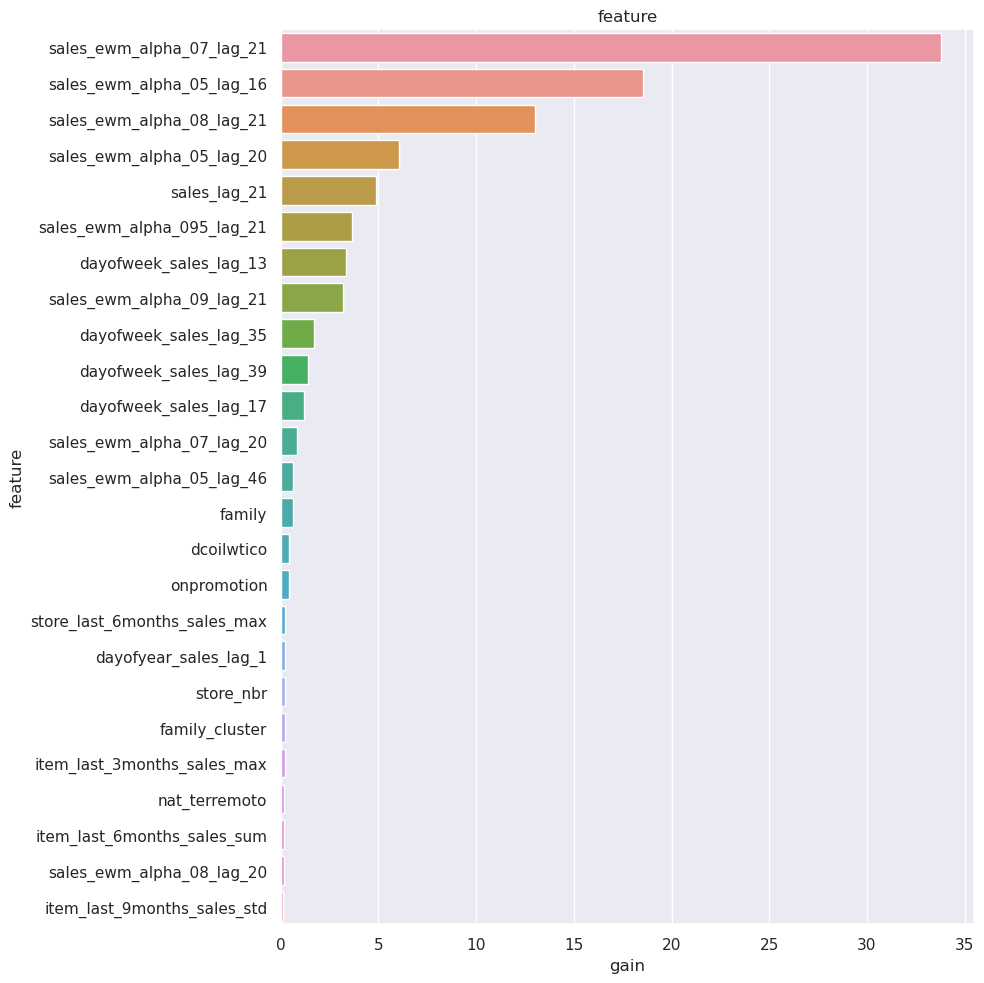

In [76]:
plot_lgb_importances(first_model, plot=True, num=10)

how can we notice the most important features are new

In [77]:
# feature importance
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

Independent Variables: 107


In [78]:
X_train[cols]

sales_ewm_alpha_07_lag_21  sales_ewm_alpha_05_lag_16  \
0                            0.00                       0.00   
1                            0.00                       0.00   
2                            0.00                       0.00   
3                            0.00                       0.00   
4                            0.00                       0.00   
...                           ...                        ...   
867829                     620.61                     590.46   
867830                      15.73                      16.71   
867831                      10.41                       3.96   
867832                     270.03                     536.31   
867833                      11.78                       6.29   

        sales_ewm_alpha_08_lag_21  sales_ewm_alpha_05_lag_20  sales_lag_21  \
0                            0.00                       0.00          0.00   
1                            0.00                       0.00          0.00   
2                            0.00                       0.00          0.00   
3                            0.00                       0.00          0.00   
4                            0.00                       0.00          0.00   
...                           ...                        ...           ...   
867829                     630.33                     617.46        652.52   
867830                      16.22                      17.31         17.00   
867831                      10.24                       7.43         10.00   
867832                     276.29                     283.15        285.69   
867833                      12.81                      10.58         15.00   

        sales_ewm_alpha_095_lag_21  dayofweek_sales_lag_13  \
0                             0.00                    0.00   
1                             0.00                    0.00   
2                             0.00                    0.00   
3                             0.00                    0.00   
4                             0.00                    0.00   
...                            ...                     ...   
867829                      646.99                  706.60   
867830                       16.84                   21.00   
867831                       10.05                    9.00   
867832                      283.82                  188.00   
867833                       14.45                    0.00   

        sales_ewm_alpha_09_lag_21  dayofweek_sales_lag_35  \
0                            0.00                    0.00   
1                            0.00                    0.00   
2                            0.00                    0.00   
3                            0.00                    0.00   
4                            0.00                    0.00   
...                           ...                     ...   
867829                     641.37                  584.53   
867830                      16.65                   15.00   
867831                      10.10                   12.00   
867832                     281.60                  210.43   
867833                      13.89                   15.00   

        dayofweek_sales_lag_39  dayofweek_sales_lag_17  \
0                         0.00                    0.00   
1                         0.00                    0.00   
2                         0.00                    0.00   
3                         0.00                    0.00   
4                         0.00                    0.00   
...                        ...                     ...   
867829                  615.95                  618.03   
867830                   21.00                   35.00   
867831                    8.00                   10.00   
867832                  230.00                  237.04   
867833                   21.14                    0.00   

        sales_ewm_alpha_07_lag_20  sales_ewm_alpha_05_lag_46  \
0                            0.00                       0.00   

In [79]:
second_model = lgb.LGBMRegressor(random_state=384
                                ).fit(X_train[cols], 
                                      Y_train, 
                                      eval_metric= lambda y_true, y_pred: [mean_squared_error(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val[cols])))

TRAIN SMAPE: 86.42733480086751
VALID SMAPE: 63.83812745714261


In [80]:
train = data_analyses.loc[data_analyses['test'] == 0]
test = data_analyses.loc[data_analyses['test'] == 1]

X = train[cols]
y = train[target]

In [81]:
def metrics_regression(y_true, y_pred):
    #MSE
    mse = mean_squared_error(y_true, y_pred)
    #RMSE Root Mean Square Error
    rmse = math.sqrt(mse)
    #SMAPE(symmetric mean absolute percentage error)
    smape = 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    return mse,rmse,smape

In [82]:
%%time
num_folds = 5
tscv = TimeSeriesSplit(n_splits=num_folds)

mse_scores = defaultdict(list)
rmse_scores = defaultdict(list)
smape_scores = defaultdict(list)
models = defaultdict(list)

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgbm = lgb.LGBMRegressor(random_state=42)
    
    object_cols = list(X_train.loc[:,X_train.dtypes==np.object].columns)
    
    for c in object_cols:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

    model_lgbm.fit(X_train, y_train,
                   categorical_feature = object_cols)

    y_pred_LGBM = model_lgbm.predict(X_test)

    models['lgbm'].append(model_lgbm)
    
    mse_LGBM,rmse_LGBM,smape_LGBM = metrics_regression(y_test, y_pred_LGBM)

    mse_scores['lgbm'].append(mse_LGBM)
    rmse_scores['lgbm'].append(rmse_LGBM)
    smape_scores['lgbm'].append(smape_LGBM)
    
    print(f"\t Score for LGBM: {mse_scores,rmse_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t LGBM: {np.mean(mse_scores['lgbm'])}")
print(f"\t\t Mean RMSE \n\t LGBM: {np.mean(rmse_scores['lgbm'])}")
print(f"\t\t Mean SMAPE \n\t LGBM: {np.mean(smape_scores['lgbm'])}")
print('*'*60)

Fold 1
	 Score for LGBM: (defaultdict(<class 'list'>, {'lgbm': [197153.69660671125]}), defaultdict(<class 'list'>, {'lgbm': [444.0199281639409]}), defaultdict(<class 'list'>, {'lgbm': [105.7185792554516]}))
************************************************************
Fold 2
	 Score for LGBM: (defaultdict(<class 'list'>, {'lgbm': [197153.69660671125, 257015.28214853967]}), defaultdict(<class 'list'>, {'lgbm': [444.0199281639409, 506.96674659048364]}), defaultdict(<class 'list'>, {'lgbm': [105.7185792554516, 95.45759571092393]}))
************************************************************
Fold 3
	 Score for LGBM: (defaultdict(<class 'list'>, {'lgbm': [197153.69660671125, 257015.28214853967, 152382.84290377944]}), defaultdict(<class 'list'>, {'lgbm': [444.0199281639409, 506.96674659048364, 390.362450683694]}), defaultdict(<class 'list'>, {'lgbm': [105.7185792554516, 95.45759571092393, 82.0863382819422]}))
************************************************************
Fold 4
	 Score for LGB

In [ ]:
"""
model = lgb.LGBMRegressor(random_state=42)
num_folds = 4
tscv = TimeSeriesSplit(n_splits=num_folds)

lgbm_params = {#"num_leaves":[20,31], # Default 31
               "max_depth":[-1, 20, 30], # Default -1
               "learning_rate":[0.1, 0.05], # Default 0.1
               "n_estimators":[100,10000], # Default 100
               #"min_split_gain":[0.0, 2,5], # Default 0
               #"min_child_samples":[10, 20, 30], # Default 20
               "colsample_bytree":[0.5, 0.8, 1.0], # Default 1
               "reg_alpha":[0.0, 0.5, 1], # Default 0
               "reg_lambda":[0.0, 0.5, 1] # Default 0
              }

rsearch = RandomizedSearchCV(model, 
                             lgbm_params, 
                             random_state=42, 
                             cv=tscv, 
                             scoring=make_scorer(smape), 
                             verbose = 10, 
                             n_jobs = -1)
rsearch.fit(X[cols], y, categorical_feature = object_cols)

print(rsearch.best_estimator_)
"""

In [ ]:
#rsearch.best_estimator_

# 5. Model comparison

In [85]:
"""
When validating time-structured models, it is important that we train 
the model on early data and test the prediction on later data.
"""
num_folds = 5
tscv = TimeSeriesSplit(n_splits=num_folds)

#creating dictionaries to record results
mse_scores = defaultdict(list)
rmse_scores = defaultdict(list)
r2_scores = defaultdict(list)
mae_scores = defaultdict(list)
mape_scores = defaultdict(list)
smape_scores = defaultdict(list)
models = defaultdict(list)

#Metrics used to evaluate models
def metrics_regression(y_true, y_pred):
    #MSE
    mse = mean_squared_error(y_true, y_pred) #!
    #RMSE Root Mean Square Error
    rmse = math.sqrt(mse)
    #R^2
    r2 = r2_score(y_true, y_pred)
    #MAE(mean absolute error)
    mae = mean_absolute_error(y_true, y_pred) #!
    #MAPE(mean absolute percentage error)
    mape = mean_absolute_percentage_error(y_true, y_pred) #!
    #SMAPE(symmetric mean absolute percentage error)
    smape = 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    
    return mse,rmse,r2,mae,mape,smape

# 5.1 LGBM Regressor

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

Light GBM is a gradient boosting framework that uses tree based learning algorithm.

In [86]:
%%time
for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgbm = lgb.LGBMRegressor(random_state=42,n_estimators=10000,
                                   colsample_bytree=0.5)
    
    object_cols = list(X_train.loc[:,X_train.dtypes==np.object].columns)
    
    for c in object_cols:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

    model_lgbm.fit(X_train, y_train,
                   categorical_feature = object_cols)

    y_pred_LGBM = model_lgbm.predict(X_test)

    models['lgbm'].append(model_lgbm)
    
    mse_LGBM,rmse_LGBM,r2_LGBM,mae_LGBM,mape_LGBM,smape_LGBM = metrics_regression(y_test, y_pred_LGBM)

    mse_scores['lgbm'].append(mse_LGBM)
    rmse_scores['lgbm'].append(rmse_LGBM)
    r2_scores['lgbm'].append(r2_LGBM)
    mae_scores['lgbm'].append(mae_LGBM)
    mape_scores['lgbm'].append(mape_LGBM)
    smape_scores['lgbm'].append(smape_LGBM)
    
    #print(f"\t Score for LGBM: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t LGBM: {np.mean(mse_scores['lgbm'])}")
print(f"\t\t Mean RMSE \n\t LGBM: {np.mean(rmse_scores['lgbm'])}")
print(f"\t\t Mean SMAPE \n\t LGBM: {np.mean(smape_scores['lgbm'])}")
print(f"\t\t Mean R2 \n\t LGBM: {np.mean(r2_scores['lgbm'])}")
print(f"\t\t Mean MAE \n\t LGBM: {np.mean(mae_scores['lgbm'])}")
print(f"\t\t Mean MAPE \n\t LGBM: {np.mean(mape_scores['lgbm'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 LGBM: 167697.16990155095
		 Mean RMSE 
	 LGBM: 405.33515796317425
		 Mean SMAPE 
	 LGBM: 86.47174301797213
		 Mean R2 
	 LGBM: 0.8338361531381053
		 Mean MAE 
	 LGBM: 106.03508738674338
		 Mean MAPE 
	 LGBM: 4.1622165582917896e+16
************************************************************
CPU times: user 4h 46min 17s, sys: 6min 1s, total: 4h 52min 19s
Wall time: 1h 31min 56s


# 5.2 Catboost

In [ ]:
#Search for optimal parameters
"""
%%time
import catboost as cb
model_cat_boost = cb.CatBoostRegressor()
grid_cat_boost = {'iterations': (300, 1000),
                  'learning_rate': [0.03, 0.1],
                  'depth': [4, 6, 10],
                  'l2_leaf_reg': [1, 3, 5, 7, 9]}

catboost_opt = GridSearchCV(model_cat_boost,
                            grid_cat_boost,
                            cv=2,
                            n_jobs=-1,
                            verbose=10)

catboost_opt.fit(X_train, y_train, cat_features=object_cols_cat,
                eval_set=[(X_test, y_test)], early_stopping_rounds=50)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", catboost_opt.best_estimator_)
print("\n The best score across ALL searched params:\n", catboost_opt.best_score_)
print("\n The best parameters across ALL searched params:\n", catboost_opt.best_params_)
"""

In [89]:
object_cols_cb=['family','store_nbr','family_cluster','store_cluster']

In [90]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_cb = cb.CatBoostRegressor(random_seed=42)
    
    #object_cols = list(X_train.loc[:,X_train.dtypes==np.object].columns)
    
    for c in object_cols_cb:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

    model_cb.fit(X_train, y_train, cat_features=object_cols_cb,
                 #eval_set=[(X_test, y_test)], 
                 #early_stopping_rounds=50
                )

    y_pred_cb = model_cb.predict(X_test)

    models['catboost_model'].append(model_cb)

    mse_cb, rmse_cb, r2_cb, mae_cb, mape_cb, smape_cb = metrics_regression(
        y_test, y_pred_cb)

    mse_scores['catboost_model'].append(mse_cb)
    rmse_scores['catboost_model'].append(rmse_cb)
    r2_scores['catboost_model'].append(r2_cb)
    mae_scores['catboost_model'].append(mae_cb)
    mape_scores['catboost_model'].append(mape_cb)
    smape_scores['catboost_model'].append(smape_cb)
    
    #print(f"\t Score for catboost_model: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t catboost_model: {np.mean(mse_scores['catboost_model'])}")
print(f"\t\t Mean RMSE \n\t catboost_model: {np.mean(rmse_scores['catboost_model'])}")
print(f"\t\t Mean R2 \n\t catboost_model: {np.mean(r2_scores['catboost_model'])}")
print(f"\t\t Mean MAE \n\t catboost_model: {np.mean(mae_scores['catboost_model'])}")
print(f"\t\t Mean MAPE \n\t catboost_model: {np.mean(mape_scores['catboost_model'])}")
print(f"\t\t Mean SMAPE \n\t catboost_model: {np.mean(smape_scores['catboost_model'])}")
print('*'*60)

Fold 1
Learning rate set to 0.091921
0:	learn: 613.3285367	total: 220ms	remaining: 3m 39s
1:	learn: 567.4041938	total: 355ms	remaining: 2m 56s
2:	learn: 525.3645626	total: 476ms	remaining: 2m 38s
3:	learn: 486.3464833	total: 596ms	remaining: 2m 28s
4:	learn: 450.6769322	total: 714ms	remaining: 2m 22s
5:	learn: 418.7732583	total: 854ms	remaining: 2m 21s
6:	learn: 389.7634958	total: 977ms	remaining: 2m 18s
7:	learn: 364.2512514	total: 1.09s	remaining: 2m 15s
8:	learn: 341.2169906	total: 1.21s	remaining: 2m 13s
9:	learn: 320.7891505	total: 1.33s	remaining: 2m 11s
10:	learn: 302.3434256	total: 1.43s	remaining: 2m 8s
11:	learn: 285.6734121	total: 1.55s	remaining: 2m 7s
12:	learn: 270.8244744	total: 1.67s	remaining: 2m 6s
13:	learn: 257.9423571	total: 1.77s	remaining: 2m 4s
14:	learn: 246.8401183	total: 1.87s	remaining: 2m 2s
15:	learn: 237.0397395	total: 1.99s	remaining: 2m 2s
16:	learn: 228.0884749	total: 2.11s	remaining: 2m 1s
17:	learn: 220.4985279	total: 2.23s	remaining: 2m 1s
18:	learn

# 5.3 Linear Regression 

In [91]:
#X.dtypes [X.dtypes != 'float64']
object_cols_lr=['family','store_nbr','family_cluster','store_cluster']

for c in object_cols_lr:
    X[c] = X[c].astype('category')
    
category_cols_lr=['family','store_nbr','family_cluster','store_cluster']
numeric_cols = list(X.select_dtypes(exclude='category').columns)

cols_for_oh = [list(X.columns).index(col) for col in category_cols_lr]
numeric_cols_idx = [list(X.columns).index(col) for col in numeric_cols]

t = [('OneHotEncoder', OneHotEncoder(), cols_for_oh),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)
    ]

col_transform = ColumnTransformer(transformers=t)

In [92]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_LR = Pipeline([("column_transformer",col_transform),
                        ("linear_regression", LinearRegression())])

    pipe_LR.fit(X_train, y_train)

    y_pred_LR = pipe_LR.predict(X_test)

    models['linear_regression'].append(pipe_LR)
    
    mse_lr,rmse_lr,r2_lr,mae_lr,mape_lr,smape_lr = metrics_regression(y_test, y_pred_LR)

    mse_scores['linear_regression'].append(mse_lr)
    rmse_scores['linear_regression'].append(rmse_lr)
    r2_scores['linear_regression'].append(r2_lr)
    mae_scores['linear_regression'].append(mae_lr)
    mape_scores['linear_regression'].append(mape_lr)
    smape_scores['linear_regression'].append(smape_lr)
    #rmsle_scores['linear_regression'].append(rmsle_lr)
    
    #print(f"\t Score for linear regression: {mse_scores,rmse_scores,r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t LR: {np.mean(mse_scores['linear_regression'])}")
print(f"\t\t Mean RMSE \n\t LR: {np.mean(rmse_scores['linear_regression'])}")
print(f"\t\t Mean R2 \n\t LR: {np.mean(r2_scores['linear_regression'])}")
print(f"\t\t Mean MAE \n\t LR: {np.mean(mae_scores['linear_regression'])}")
print(f"\t\t Mean MAPE \n\t LR: {np.mean(mape_scores['linear_regression'])}")
print(f"\t\t Mean SMAPE \n\t LR: {np.mean(smape_scores['linear_regression'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 LR: 186377138.88678402
		 Mean RMSE 
	 LR: 6444.559993101588
		 Mean R2 
	 LR: -127.50112056598098
		 Mean MAE 
	 LR: 1072.3656849671513
		 Mean MAPE 
	 LR: 2.0505772268120438e+17
		 Mean SMAPE 
	 LR: 129.0687896645959
************************************************************
CPU times: user 2min 4s, sys: 30.1 s, total: 2min 35s
Wall time: 1min 17s


# 5.4 DecisionTreeRegressor

!!!**the calculation is made, but does not participate in the selection of the optimal model due to instability**

Since the decision tree regressor parameters are so important, it is recommended to use the GridCV parameter search optimization tool from sklearn to find the correct recommendations for this model.

When formally evaluating performance, use K-fold testing instead of standard train-test-split to avoid the randomness of the latter, which could disrupt the sensitive results of a high-variance model.

In [ ]:
#Search for optimal parameters
"""
param_grid = {
    "decision_tree__max_depth": [3, 5, 10],
    "decision_tree__min_samples_split": [10, 200],
    "decision_tree__min_impurity_decrease": [0, 0.1],
    "decision_tree__max_leaf_nodes": [100, 1000]
}
pipe_DTR = Pipeline([("column_transformer",
                      col_transform),
                     ("decision_tree", 
                      DecisionTreeRegressor())])

search = GridSearchCV(pipe_DTR, param_grid, 
                      cv=tscv,scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X, y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)
"""

In [93]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_DTR = Pipeline([("column_transformer",col_transform),
                         ("decision_tree", 
                          DecisionTreeRegressor())])

    pipe_DTR.fit(X_train, y_train)

    y_pred_DTR = pipe_DTR.predict(X_test)

    models['decision_tree'].append(pipe_DTR)
    
    mse_dtr,rmse_dtr,r2_dtr,mae_dtr,mape_dtr,smape_dtr = metrics_regression(y_test, y_pred_DTR)

    mse_scores['decision_tree'].append(mse_dtr)
    rmse_scores['decision_tree'].append(rmse_dtr)
    r2_scores['decision_tree'].append(r2_dtr)
    mae_scores['decision_tree'].append(mae_dtr)
    mape_scores['decision_tree'].append(mape_dtr)
    smape_scores['decision_tree'].append(smape_dtr)
    
    #print(f"\t Score for decision_tree: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t DTR: {np.mean(mse_scores['decision_tree'])}")
print(f"\t\t Mean RMSE \n\t DTR: {np.mean(rmse_scores['decision_tree'])}")
print(f"\t\t Mean R2 \n\t DTR: {np.mean(r2_scores['decision_tree'])}")
print(f"\t\t Mean MAE \n\t DTR: {np.mean(mae_scores['decision_tree'])}")
print(f"\t\t Mean MAPE \n\t DTR: {np.mean(mape_scores['decision_tree'])}")
print(f"\t\t Mean SMAPE \n\t DTR: {np.mean(smape_scores['decision_tree'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 DTR: 283527.77924953826
		 Mean RMSE 
	 DTR: 526.3746336399364
		 Mean R2 
	 DTR: 0.7410867554298047
		 Mean MAE 
	 DTR: 119.17728524724866
		 Mean MAPE 
	 DTR: 2.883069506460499e+16
		 Mean SMAPE 
	 DTR: 63.50094422685537
************************************************************
CPU times: user 10min 51s, sys: 7.58 s, total: 10min 59s
Wall time: 11min 5s


# 5.5 LASSO Regression

In [ ]:
"""
pipe_lasso = Pipeline([("column_transformer",col_transform),
                       ("Lasso", Lasso())])

alphas = np.linspace(start=0.01, stop=1, num=30)

param_grid = {"Lasso__alpha": alphas}

search_lasso = GridSearchCV(pipe_lasso, param_grid,
                            cv=tscv,scoring='neg_mean_squared_error',
                            verbose=10)

search_lasso.fit(X, y)

print(f"Best parameter (CV score={search_lasso.best_score_:.5f}):")
print(search_lasso.best_params_)
"""

In [94]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_lasso = Pipeline([("column_transformer",col_transform),
                           ("Lasso", Lasso())])

    pipe_lasso.fit(X_train, y_train)

    y_pred_lasso = pipe_lasso.predict(X_test)

    models['Lasso'].append(pipe_lasso)
    
    mse_lasso,rmse_lasso,r2_lasso,mae_lasso,mape_lasso,smape_lasso = metrics_regression(
        y_test, y_pred_lasso)

    mse_scores['Lasso'].append(mse_lasso)
    rmse_scores['Lasso'].append(rmse_lasso)
    r2_scores['Lasso'].append(r2_lasso)
    mae_scores['Lasso'].append(mae_lasso)
    mape_scores['Lasso'].append(mape_lasso)
    smape_scores['Lasso'].append(smape_lasso)
    
    #print(f"\t Score for Lasso: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t Lasso: {np.mean(mse_scores['Lasso'])}")
print(f"\t\t Mean RMSE \n\t Lasso: {np.mean(rmse_scores['Lasso'])}")
print(f"\t\t Mean R2 \n\t Lasso: {np.mean(r2_scores['Lasso'])}")
print(f"\t\t Mean MAE \n\t Lasso: {np.mean(mae_scores['Lasso'])}")
print(f"\t\t Mean MAPE \n\t Lasso: {np.mean(mape_scores['Lasso'])}")
print(f"\t\t Mean SMAPE \n\t Lasso: {np.mean(smape_scores['Lasso'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 Lasso: 145727.6737291878
		 Mean RMSE 
	 Lasso: 379.8940187191824
		 Mean R2 
	 Lasso: 0.8584271995586541
		 Mean MAE 
	 Lasso: 116.92034669672475
		 Mean MAPE 
	 Lasso: 6.553337910202363e+16
		 Mean SMAPE 
	 Lasso: 107.27435252425289
************************************************************
CPU times: user 25min 21s, sys: 2min 58s, total: 28min 20s
Wall time: 7min 41s


# 5.6 RIDGE Regression

In [ ]:
#Search for optimal parameters
"""
pipe_ridge = Pipeline([("column_transformer",col_transform),
                       ("Ridge", Ridge())])

alphas = np.linspace(start=0.01, stop=1, num=30)

param_grid = {"Ridge__alpha": alphas}

search_ridge = GridSearchCV(pipe_ridge, param_grid,
                            cv=tscv,scoring='neg_mean_squared_error',verbose=10)

search_ridge.fit(X, y)

print(f"Best parameter (CV score={search_ridge.best_score_:.5f}):")
print(search_ridge.best_params_)
"""

In [95]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_ridge = Pipeline([("column_transformer",col_transform),
                           ("Ridge", Ridge())])

    pipe_ridge.fit(X_train, y_train)

    y_pred_ridge = pipe_ridge.predict(X_test)

    models['Ridge'].append(pipe_ridge)
    
    mse_ridge, rmse_ridge, r2_ridge, mae_ridge, mape_ridge, smape_ridge = metrics_regression(
        y_test, y_pred_ridge)

    mse_scores['Ridge'].append(mse_ridge)
    rmse_scores['Ridge'].append(rmse_ridge)
    r2_scores['Ridge'].append(r2_ridge)
    mae_scores['Ridge'].append(mae_ridge)
    mape_scores['Ridge'].append(mape_ridge)
    smape_scores['Ridge'].append(smape_ridge)
    
    #print(f"\t Score for Ridge: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t Ridge: {np.mean(mse_scores['Ridge'])}")
print(f"\t\t Mean RMSE \n\t Ridge: {np.mean(rmse_scores['Ridge'])}")
print(f"\t\t Mean R2 \n\t Ridge: {np.mean(r2_scores['Ridge'])}")
print(f"\t\t Mean MAE \n\t Ridge: {np.mean(mae_scores['Ridge'])}")
print(f"\t\t Mean MAPE \n\t Ridge: {np.mean(mape_scores['Ridge'])}")
print(f"\t\t Mean SMAPE \n\t Ridge: {np.mean(smape_scores['Ridge'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 Ridge: 644372.4426859005
		 Mean RMSE 
	 Ridge: 648.2378860194829
		 Mean R2 
	 Ridge: 0.504789268055221
		 Mean MAE 
	 Ridge: 185.55318501614337
		 Mean MAPE 
	 Ridge: 1.0722089755068848e+17
		 Mean SMAPE 
	 Ridge: 120.76601417166084
************************************************************
CPU times: user 33.1 s, sys: 11.7 s, total: 44.7 s
Wall time: 33.2 s


# 5.7 Elastic Net Regression

Elastic net is a popular type of regularized linear regression that combines two popular penalties, specifically the L1 and L2 penalty functions.

The scikit-learn library also provides a built-in version of the algorithm that automatically finds good hyperparameters via the ElasticNetCV class.

In [ ]:
#Search for optimal parameters
"""
pipe_en = Pipeline([("column_transformer",col_transform),
                    ("elastic_net", ElasticNet())])

param_grid =  {'elastic_net__alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
               'elastic_net__l1_ratio' : [0, 1, 0.01]}


search_en = GridSearchCV(pipe_en, param_grid, 
                         cv=tscv,scoring='neg_mean_absolute_error',verbose=10)

search_en.fit(X, y)

print(f"Best parameter (CV score={search_en.best_score_:.5f}):")
print(search_en.best_params_)
"""

In [96]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_en = Pipeline([("column_transformer",col_transform),
                        ("elastic_net", ElasticNet())])

    pipe_en.fit(X_train, y_train)

    y_pred_en = pipe_en.predict(X_test)

    models['elastic_net'].append(pipe_en)
    
    mse_en, rmse_en, r2_en, mae_en, mape_en, smape_en = metrics_regression(
        y_test, y_pred_en)

    mse_scores['elastic_net'].append(mse_en)
    rmse_scores['elastic_net'].append(rmse_en)
    r2_scores['elastic_net'].append(r2_en)
    mae_scores['elastic_net'].append(mae_en)
    mape_scores['elastic_net'].append(mape_en)
    smape_scores['elastic_net'].append(smape_en)
    
    #print(f"\t Score for elastic_net: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t elastic_net: {np.mean(mse_scores['elastic_net'])}")
print(f"\t\t Mean RMSE \n\t elastic_net: {np.mean(rmse_scores['elastic_net'])}")
print(f"\t\t Mean R2 \n\t elastic_net: {np.mean(r2_scores['elastic_net'])}")
print(f"\t\t Mean MAE \n\t elastic_net: {np.mean(mae_scores['elastic_net'])}")
print(f"\t\t Mean MAPE \n\t elastic_net: {np.mean(mape_scores['elastic_net'])}")
print(f"\t\t Mean SMAPE \n\t elastic_net: {np.mean(smape_scores['elastic_net'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 elastic_net: 141207.6040686408
		 Mean RMSE 
	 elastic_net: 373.2188095319378
		 Mean R2 
	 elastic_net: 0.8606883376849405
		 Mean MAE 
	 elastic_net: 109.01727319903173
		 Mean MAPE 
	 elastic_net: 5.94848206427594e+16
		 Mean SMAPE 
	 elastic_net: 102.55471535913075
************************************************************
CPU times: user 19min 8s, sys: 2min 16s, total: 21min 24s
Wall time: 5min 54s


# 5.8 XGBRegressor

In [ ]:
#Search for optimal parameters
"""
%%time

model_xgb = XGBRegressor(verbosity=0, tree_method='gpu_hist', gpu_id=0)

xgb_params = {
    'n_estimators': (300, 1000),
    'learning_rate': (0.001, 0.05),
    'max_depth': (3, 8),
    'subsample': (0.1, 1.0)}

xgb_opt = BayesSearchCV(model_xgb, xgb_params, n_iter=10, cv=2, n_jobs=-1, verbose=0)
xgb_opt.fit(X_train, y_train)

print('*'*60)
best_xgb_params = xgb_opt.best_params_
best_xgb_score = xgb_opt.best_score_
print("Best XGBoost params:", best_xgb_params)
print("Best XGBoost score:", best_xgb_score)
print('*'*60)

# Evaluate the models on the test set
y_pred_xgb = xgb_opt.predict(X_test)
msle_xgb = mean_squared_log_error(abs(y_test), abs(y_pred_xgb), squared=False)

print('*'*60)
print("XGBoost MSE on test set:", msle_xgb)
print('*'*60)
"""

In [97]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pipe_xgb = Pipeline([("column_transformer",col_transform),
                         ("xgbr", XGBRegressor())])

    pipe_xgb.fit(X_train, y_train)

    y_pred_xgb = pipe_xgb.predict(X_test)

    models['xgbr'].append(pipe_xgb)

    mse_xgb, rmse_xgb, r2_xgb, mae_xgb, mape_xgb, smape_xgb = metrics_regression(
        y_test, y_pred_xgb)

    mse_scores['xgbr'].append(mse_xgb)
    rmse_scores['xgbr'].append(rmse_xgb)
    r2_scores['xgbr'].append(r2_xgb)
    mae_scores['xgbr'].append(mae_xgb)
    mape_scores['xgbr'].append(mape_xgb)
    smape_scores['xgbr'].append(smape_xgb)
    
    #print(f"\t Score for xgbr: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t xgbr: {np.mean(mse_scores['xgbr'])}")
print(f"\t\t Mean RMSE \n\t xgbr: {np.mean(rmse_scores['xgbr'])}")
print(f"\t\t Mean R2 \n\t xgbr: {np.mean(r2_scores['xgbr'])}")
print(f"\t\t Mean MAE \n\t xgbr: {np.mean(mae_scores['xgbr'])}")
print(f"\t\t Mean MAPE \n\t xgbr: {np.mean(mape_scores['xgbr'])}")
print(f"\t\t Mean SMAPE \n\t xgbr: {np.mean(smape_scores['xgbr'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 xgbr: 171835.3019844264
		 Mean RMSE 
	 xgbr: 409.2858100344905
		 Mean R2 
	 xgbr: 0.8294292096088982
		 Mean MAE 
	 xgbr: 102.24172665386382
		 Mean MAPE 
	 xgbr: 3.367600684004468e+16
		 Mean SMAPE 
	 xgbr: 87.16497402824507
************************************************************
CPU times: user 59min 33s, sys: 12.7 s, total: 59min 46s
Wall time: 59min 57s


Let's choose the best model!

In [104]:
# !the calculation is made, but does not participate in the selection of the optimal model due to instability
del mse_scores['decision_tree']
del rmse_scores['decision_tree']
del mae_scores['decision_tree']
del mape_scores['decision_tree']
del smape_scores['decision_tree']

In [105]:
df_mse = pd.DataFrame.from_dict(data=mse_scores, orient='index', columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_mse['mean'] = df_mse[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_mse

fold_1    fold_2    fold_3    fold_4       fold_5  \
lgbm              151517.25 207463.46 155968.37 227240.77     96296.00   
catboost_model    129599.75 209721.80 188541.13 223395.27     94076.41   
linear_regression 268400.57 125000.06 138350.63 215911.73 931138031.45   
Lasso             147455.25 129900.66 124571.47 203554.00    123156.98   
Ridge             211606.16 124017.03 138305.11 217533.72   2530400.20   
elastic_net       151927.20 133384.43 118913.80 200079.96    101732.62   
xgbr              141492.25 240653.72 150481.71 227314.19     99234.63   

                          mean  
lgbm                 167697.17  
catboost_model       169066.87  
linear_regression 186377138.89  
Lasso                145727.67  
Ridge                644372.44  
elastic_net          141207.60  
xgbr                 171835.30

<Axes: >

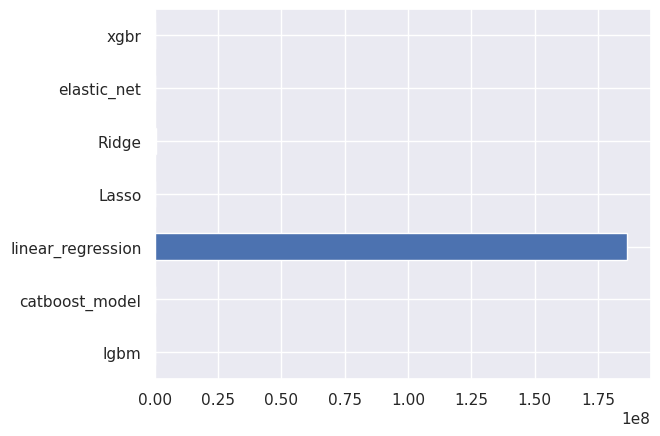

In [106]:
df_mse['mean'].plot.barh()

Such an anomaly for linear regression can be explained by an outlier in the data on fold 5.

In [107]:
df_rmse = pd.DataFrame.from_dict(data=rmse_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_rmse['mean'] = df_rmse[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_rmse

fold_1  fold_2  fold_3  fold_4   fold_5    mean
lgbm               389.25  455.48  394.93  476.70   310.32  405.34
catboost_model     360.00  457.95  434.21  472.65   306.72  406.31
linear_regression  518.07  353.55  371.96  464.66 30514.55 6444.56
Lasso              384.00  360.42  352.95  451.17   350.94  379.89
Ridge              460.01  352.16  371.89  466.41  1590.72  648.24
elastic_net        389.78  365.22  344.84  447.30   318.96  373.22
xgbr               376.15  490.56  387.92  476.77   315.02  409.29

<Axes: >

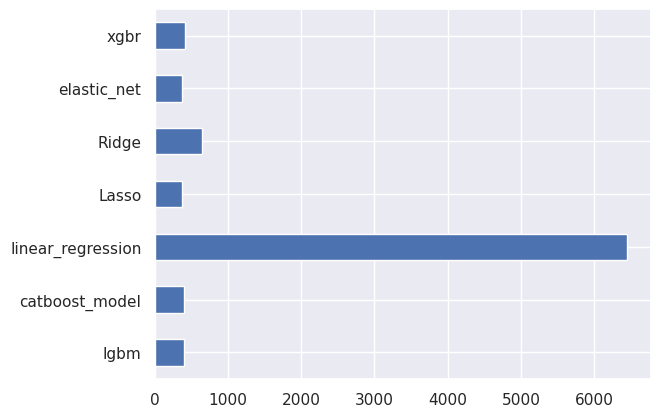

In [108]:
df_rmse['mean'].plot.barh()

In [109]:
df_mae = pd.DataFrame.from_dict(data=mae_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_mae['mean'] = df_mae[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_mae

fold_1  fold_2  fold_3  fold_4  fold_5    mean
lgbm               106.04  144.72  101.18   96.43   81.80  106.04
catboost_model      93.27  149.01  109.80   96.09   78.94  105.42
linear_regression  241.48  152.51  121.12  106.73 4739.99 1072.37
Lasso              106.70  168.25  107.27   95.98  106.41  116.92
Ridge              211.99  151.86  121.39  106.25  336.29  185.55
elastic_net        104.65  157.52   98.60   93.21   91.11  109.02
xgbr                91.94  146.67   98.84   93.81   79.95  102.24

<Axes: >

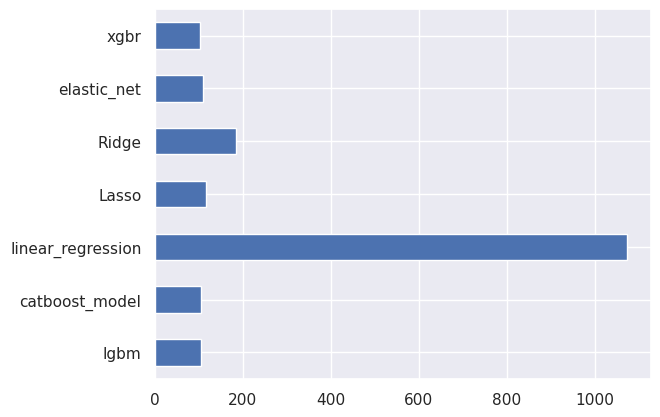

In [110]:
df_mae['mean'].plot.barh()

In [111]:
df_mape = pd.DataFrame.from_dict(data=mape_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_mape['mean'] = df_mape[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_mape

fold_1                fold_2  \
lgbm               34568416435157952.00 118562864214286208.00   
catboost_model     36399575943563976.00 112859789948108672.00   
linear_regression 265846453569551968.00 136848689345130960.00   
Lasso              66725781261624872.00 168557516172097728.00   
Ridge             241853697867375616.00 135333511607366768.00   
elastic_net        57513729291784096.00 155175753002340992.00   
xgbr               29914333903543404.00  86436317779183456.00   

                                fold_3               fold_4  \
lgbm              12996798565515714.00 23753346568224824.00   
catboost_model    17851648726529204.00 25904172039880564.00   
linear_regression 43937576579098960.00 39014961313365736.00   
Lasso             29304907966525628.00 29837171521169976.00   
Ridge             44381872914939104.00 38463956986701008.00   
elastic_net       29993847882919656.00 28465605454605532.00   
xgbr              13440698825066738.00 19629095292617432.00   

                                 fold_5                  mean  
lgbm               18229402131404772.00  41622165582917896.00  
catboost_model     18844703702732052.00  42371978072162896.00  
linear_regression 539640932598874304.00 205057722681204384.00  
Lasso              33241518588699944.00  65533379102023632.00  
Ridge              76071448377059936.00 107220897550688480.00  
elastic_net        26275167582146752.00  59484820642759400.00  
xgbr               18959588399812364.00  33676006840044680.00

<Axes: >

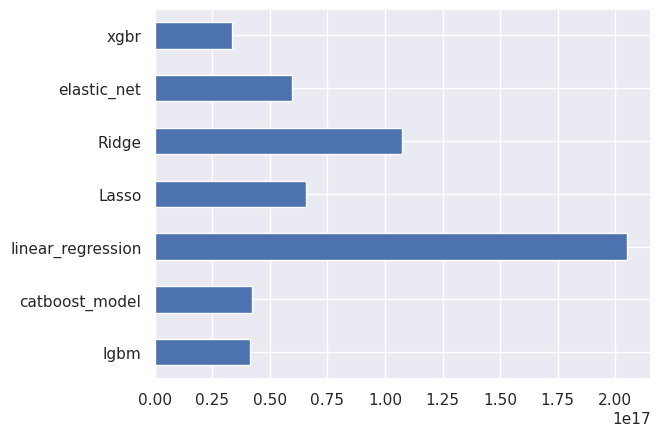

In [112]:
df_mape['mean'].plot.barh()

In [113]:
df_smape = pd.DataFrame.from_dict(data=smape_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_smape['mean'] = df_smape[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_smape

fold_1  fold_2  fold_3  fold_4  fold_5   mean
lgbm               108.70  106.53   80.31   69.73   67.09  86.47
catboost_model     111.76  109.77   93.74   78.45   70.65  92.87
linear_regression  141.88  119.36  111.10  107.22  165.79 129.07
Lasso              124.36  121.62   98.26   99.48   92.64 107.27
Ridge              139.65  119.10  111.65  107.25  126.18 120.77
elastic_net        116.96  119.82   96.77   95.83   83.38 102.55
xgbr               113.29   96.56   85.01   71.46   69.51  87.16

<Axes: >

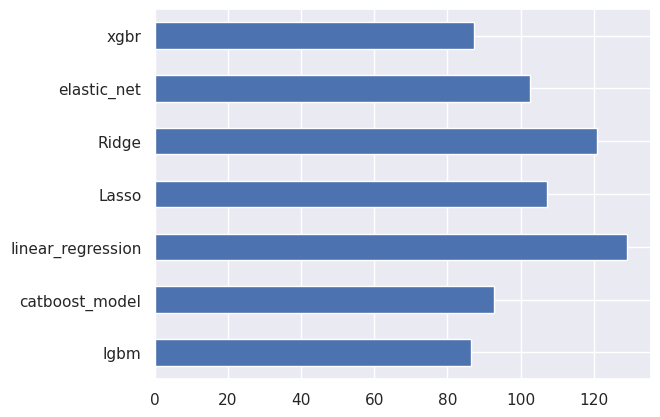

In [114]:
df_smape['mean'].plot.barh()

# 6. Let's get predictions

As we can see XGBoost model shows itself best, so let’s continue working with it

In [115]:
result = pipe_xgb.predict(test[cols])
sample_submission = pd.DataFrame({'id':test.id,'sales':result}).set_index('id')
sample_submission

sales
id                
3000991.00    2.17
3000917.00   54.28
3001151.00    0.82
3001145.00    0.13
3002601.00 7630.08
...            ...
3029302.00    3.27
3029303.00   12.48
3029304.00 4054.22
3029306.00  683.15
3029087.00    0.08

[9504 rows x 1 columns]

Let's save the results to csv

In [116]:
sample_submission.to_csv('submission.csv', index=False)